In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 1000,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1000_1_025_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1004099, 828)
(1004099, 1)
validation
(118499, 828)
(118499, 1)
test
(140352, 828)
(140352, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/101 [..............................] - ETA: 2:00 - loss: 0.0472 - STD: 1.7170e-04 - MAE: 0.1894

  5/101 [>.............................] - ETA: 1s - loss: 0.0370 - STD: 3.4498e-04 - MAE: 0.1483  

  8/101 [=>............................] - ETA: 1s - loss: 0.0333 - STD: 4.6928e-04 - MAE: 0.1408

 12/101 [==>...........................] - ETA: 1s - loss: 0.0313 - STD: 6.9205e-04 - MAE: 0.1420

 16/101 [===>..........................] - ETA: 1s - loss: 0.0295 - STD: 8.4999e-04 - MAE: 0.1387

 20/101 [====>.........................] - ETA: 1s - loss: 0.0287 - STD: 9.7766e-04 - MAE: 0.1360

 24/101 [======>.......................] - ETA: 1s - loss: 0.0278 - STD: 0.0012 - MAE: 0.1346    

 27/101 [=======>......................] - ETA: 1s - loss: 0.0274 - STD: 0.0013 - MAE: 0.1345

 31/101 [========>.....................] - ETA: 1s - loss: 0.0268 - STD: 0.0016 - MAE: 0.1336

 34/101 [=========>....................] - ETA: 1s - loss: 0.0265 - STD: 0.0018 - MAE: 0.1328

 37/101 [=========>....................] - ETA: 1s - loss: 0.0262 - STD: 0.0020 - MAE: 0.1322

 41/101 [===========>..................] - ETA: 0s - loss: 0.0258 - STD: 0.0025 - MAE: 0.1318

 45/101 [============>.................] - ETA: 0s - loss: 0.0255 - STD: 0.0031 - MAE: 0.1314

 48/101 [=============>................] - ETA: 1s - loss: 0.0253 - STD: 0.0036 - MAE: 0.1308

 52/101 [==============>...............] - ETA: 1s - loss: 0.0250 - STD: 0.0047 - MAE: 0.1302

 56/101 [===============>..............] - ETA: 1s - loss: 0.0247 - STD: 0.0062 - MAE: 0.1295

 59/101 [================>.............] - ETA: 1s - loss: 0.0244 - STD: 0.0076 - MAE: 0.1289

 63/101 [=================>............] - ETA: 0s - loss: 0.0240 - STD: 0.0101 - MAE: 0.1280

 67/101 [==================>...........] - ETA: 0s - loss: 0.0237 - STD: 0.0130 - MAE: 0.1270

 70/101 [===================>..........] - ETA: 0s - loss: 0.0234 - STD: 0.0153 - MAE: 0.1262

 74/101 [====================>.........] - ETA: 0s - loss: 0.0231 - STD: 0.0184 - MAE: 0.1253

 78/101 [======================>.......] - ETA: 0s - loss: 0.0228 - STD: 0.0212 - MAE: 0.1243

 81/101 [=======================>......] - ETA: 0s - loss: 0.0226 - STD: 0.0230 - MAE: 0.1237

 85/101 [========================>.....] - ETA: 0s - loss: 0.0224 - STD: 0.0251 - MAE: 0.1229

 88/101 [=========================>....] - ETA: 0s - loss: 0.0222 - STD: 0.0266 - MAE: 0.1223

 92/101 [==========================>...] - ETA: 0s - loss: 0.0219 - STD: 0.0286 - MAE: 0.1214

 96/101 [===========================>..] - ETA: 0s - loss: 0.0217 - STD: 0.0306 - MAE: 0.1205

 99/101 [============================>.] - ETA: 0s - loss: 0.0215 - STD: 0.0321 - MAE: 0.1198

101/101 [==============================] - 4s 29ms/step - loss: 0.0214 - STD: 0.0331 - MAE: 0.1194 - val_loss: 0.0130 - val_STD: 0.0624 - val_MAE: 0.0911


Epoch 2/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0152 - STD: 0.0789 - MAE: 0.0961

  4/101 [>.............................] - ETA: 1s - loss: 0.0150 - STD: 0.0821 - MAE: 0.0956

  7/101 [=>............................] - ETA: 1s - loss: 0.0145 - STD: 0.0834 - MAE: 0.0941

 11/101 [==>...........................] - ETA: 1s - loss: 0.0143 - STD: 0.0855 - MAE: 0.0929

 15/101 [===>..........................] - ETA: 1s - loss: 0.0141 - STD: 0.0886 - MAE: 0.0922

 19/101 [====>.........................] - ETA: 1s - loss: 0.0140 - STD: 0.0908 - MAE: 0.0913

 22/101 [=====>........................] - ETA: 1s - loss: 0.0139 - STD: 0.0920 - MAE: 0.0908

 25/101 [======>.......................] - ETA: 1s - loss: 0.0138 - STD: 0.0927 - MAE: 0.0903

 28/101 [=======>......................] - ETA: 1s - loss: 0.0137 - STD: 0.0932 - MAE: 0.0899

 32/101 [========>.....................] - ETA: 1s - loss: 0.0136 - STD: 0.0936 - MAE: 0.0894

 35/101 [=========>....................] - ETA: 1s - loss: 0.0135 - STD: 0.0940 - MAE: 0.0890

 38/101 [==========>...................] - ETA: 1s - loss: 0.0134 - STD: 0.0944 - MAE: 0.0886

 41/101 [===========>..................] - ETA: 1s - loss: 0.0134 - STD: 0.0948 - MAE: 0.0884

 44/101 [============>.................] - ETA: 0s - loss: 0.0133 - STD: 0.0952 - MAE: 0.0881

 47/101 [============>.................] - ETA: 0s - loss: 0.0132 - STD: 0.0955 - MAE: 0.0877

 50/101 [=============>................] - ETA: 0s - loss: 0.0132 - STD: 0.0958 - MAE: 0.0875

 54/101 [===============>..............] - ETA: 0s - loss: 0.0131 - STD: 0.0962 - MAE: 0.0871

 58/101 [================>.............] - ETA: 0s - loss: 0.0131 - STD: 0.0968 - MAE: 0.0869

 62/101 [=================>............] - ETA: 0s - loss: 0.0130 - STD: 0.0971 - MAE: 0.0866

 66/101 [==================>...........] - ETA: 0s - loss: 0.0129 - STD: 0.0973 - MAE: 0.0863

 69/101 [===================>..........] - ETA: 0s - loss: 0.0129 - STD: 0.0975 - MAE: 0.0861

 72/101 [====================>.........] - ETA: 0s - loss: 0.0128 - STD: 0.0977 - MAE: 0.0858

 76/101 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 0.0982 - MAE: 0.0855

 80/101 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 0.0986 - MAE: 0.0852

 83/101 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 0.0989 - MAE: 0.0849

 87/101 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 0.0993 - MAE: 0.0846

 90/101 [=========================>....] - ETA: 0s - loss: 0.0125 - STD: 0.0996 - MAE: 0.0844

 94/101 [==========================>...] - ETA: 0s - loss: 0.0124 - STD: 0.1000 - MAE: 0.0840

 98/101 [============================>.] - ETA: 0s - loss: 0.0123 - STD: 0.1004 - MAE: 0.0838

101/101 [==============================] - 2s 19ms/step - loss: 0.0123 - STD: 0.1006 - MAE: 0.0836 - val_loss: 0.0088 - val_STD: 0.0893 - val_MAE: 0.0700


Epoch 3/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0105 - STD: 0.1085 - MAE: 0.0755

  4/101 [>.............................] - ETA: 1s - loss: 0.0108 - STD: 0.1094 - MAE: 0.0771

  7/101 [=>............................] - ETA: 1s - loss: 0.0108 - STD: 0.1104 - MAE: 0.0772

 11/101 [==>...........................] - ETA: 1s - loss: 0.0109 - STD: 0.1091 - MAE: 0.0771

 15/101 [===>..........................] - ETA: 1s - loss: 0.0109 - STD: 0.1092 - MAE: 0.0773

 19/101 [====>.........................] - ETA: 1s - loss: 0.0108 - STD: 0.1092 - MAE: 0.0769

 22/101 [=====>........................] - ETA: 1s - loss: 0.0107 - STD: 0.1093 - MAE: 0.0765

 26/101 [======>.......................] - ETA: 1s - loss: 0.0106 - STD: 0.1094 - MAE: 0.0761

 30/101 [=======>......................] - ETA: 1s - loss: 0.0105 - STD: 0.1097 - MAE: 0.0758

 34/101 [=========>....................] - ETA: 1s - loss: 0.0106 - STD: 0.1100 - MAE: 0.0760

 38/101 [==========>...................] - ETA: 1s - loss: 0.0105 - STD: 0.1106 - MAE: 0.0759

 42/101 [===========>..................] - ETA: 0s - loss: 0.0105 - STD: 0.1106 - MAE: 0.0757

 45/101 [============>.................] - ETA: 0s - loss: 0.0104 - STD: 0.1108 - MAE: 0.0756

 49/101 [=============>................] - ETA: 0s - loss: 0.0104 - STD: 0.1108 - MAE: 0.0754

 53/101 [==============>...............] - ETA: 0s - loss: 0.0104 - STD: 0.1111 - MAE: 0.0752

 57/101 [===============>..............] - ETA: 0s - loss: 0.0103 - STD: 0.1114 - MAE: 0.0751

 60/101 [================>.............] - ETA: 0s - loss: 0.0104 - STD: 0.1114 - MAE: 0.0752

 64/101 [==================>...........] - ETA: 0s - loss: 0.0103 - STD: 0.1117 - MAE: 0.0752

 67/101 [==================>...........] - ETA: 0s - loss: 0.0104 - STD: 0.1117 - MAE: 0.0752

 71/101 [====================>.........] - ETA: 0s - loss: 0.0104 - STD: 0.1118 - MAE: 0.0752

 75/101 [=====================>........] - ETA: 0s - loss: 0.0104 - STD: 0.1119 - MAE: 0.0752

 78/101 [======================>.......] - ETA: 0s - loss: 0.0104 - STD: 0.1119 - MAE: 0.0753

 81/101 [=======================>......] - ETA: 0s - loss: 0.0104 - STD: 0.1120 - MAE: 0.0753

 85/101 [========================>.....] - ETA: 0s - loss: 0.0104 - STD: 0.1117 - MAE: 0.0754

 89/101 [=========================>....] - ETA: 0s - loss: 0.0105 - STD: 0.1116 - MAE: 0.0756

 93/101 [==========================>...] - ETA: 0s - loss: 0.0105 - STD: 0.1115 - MAE: 0.0756

 97/101 [===========================>..] - ETA: 0s - loss: 0.0105 - STD: 0.1115 - MAE: 0.0756

101/101 [==============================] - ETA: 0s - loss: 0.0104 - STD: 0.1114 - MAE: 0.0755

101/101 [==============================] - 2s 18ms/step - loss: 0.0104 - STD: 0.1114 - MAE: 0.0755 - val_loss: 0.0082 - val_STD: 0.0900 - val_MAE: 0.0684


Epoch 4/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0091 - STD: 0.1105 - MAE: 0.0716

  4/101 [>.............................] - ETA: 1s - loss: 0.0096 - STD: 0.1108 - MAE: 0.0731

  7/101 [=>............................] - ETA: 1s - loss: 0.0097 - STD: 0.1109 - MAE: 0.0728

 11/101 [==>...........................] - ETA: 1s - loss: 0.0097 - STD: 0.1124 - MAE: 0.0728

 15/101 [===>..........................] - ETA: 1s - loss: 0.0096 - STD: 0.1130 - MAE: 0.0724

 19/101 [====>.........................] - ETA: 1s - loss: 0.0096 - STD: 0.1134 - MAE: 0.0722

 23/101 [=====>........................] - ETA: 1s - loss: 0.0095 - STD: 0.1141 - MAE: 0.0720

 27/101 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 0.1145 - MAE: 0.0718

 31/101 [========>.....................] - ETA: 1s - loss: 0.0095 - STD: 0.1150 - MAE: 0.0716

 34/101 [=========>....................] - ETA: 1s - loss: 0.0095 - STD: 0.1153 - MAE: 0.0715

 38/101 [==========>...................] - ETA: 0s - loss: 0.0094 - STD: 0.1157 - MAE: 0.0714

 41/101 [===========>..................] - ETA: 0s - loss: 0.0094 - STD: 0.1160 - MAE: 0.0713

 45/101 [============>.................] - ETA: 0s - loss: 0.0094 - STD: 0.1161 - MAE: 0.0712

 49/101 [=============>................] - ETA: 0s - loss: 0.0094 - STD: 0.1164 - MAE: 0.0711

 53/101 [==============>...............] - ETA: 0s - loss: 0.0093 - STD: 0.1167 - MAE: 0.0711

 57/101 [===============>..............] - ETA: 0s - loss: 0.0093 - STD: 0.1168 - MAE: 0.0710

 61/101 [=================>............] - ETA: 0s - loss: 0.0093 - STD: 0.1169 - MAE: 0.0710

 65/101 [==================>...........] - ETA: 0s - loss: 0.0094 - STD: 0.1171 - MAE: 0.0711

 69/101 [===================>..........] - ETA: 0s - loss: 0.0093 - STD: 0.1172 - MAE: 0.0709

 73/101 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 0.1172 - MAE: 0.0709

 77/101 [=====================>........] - ETA: 0s - loss: 0.0093 - STD: 0.1173 - MAE: 0.0709

 81/101 [=======================>......] - ETA: 0s - loss: 0.0093 - STD: 0.1173 - MAE: 0.0708

 85/101 [========================>.....] - ETA: 0s - loss: 0.0093 - STD: 0.1174 - MAE: 0.0709

 89/101 [=========================>....] - ETA: 0s - loss: 0.0093 - STD: 0.1176 - MAE: 0.0708

 93/101 [==========================>...] - ETA: 0s - loss: 0.0093 - STD: 0.1176 - MAE: 0.0708

 97/101 [===========================>..] - ETA: 0s - loss: 0.0093 - STD: 0.1176 - MAE: 0.0708

101/101 [==============================] - ETA: 0s - loss: 0.0093 - STD: 0.1177 - MAE: 0.0707

101/101 [==============================] - 2s 18ms/step - loss: 0.0093 - STD: 0.1177 - MAE: 0.0707 - val_loss: 0.0078 - val_STD: 0.0971 - val_MAE: 0.0663


Epoch 5/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0092 - STD: 0.1227 - MAE: 0.0717

  5/101 [>.............................] - ETA: 1s - loss: 0.0090 - STD: 0.1200 - MAE: 0.0696

  9/101 [=>............................] - ETA: 1s - loss: 0.0090 - STD: 0.1192 - MAE: 0.0694

 13/101 [==>...........................] - ETA: 1s - loss: 0.0096 - STD: 0.1182 - MAE: 0.0720

 17/101 [====>.........................] - ETA: 1s - loss: 0.0096 - STD: 0.1189 - MAE: 0.0721

 21/101 [=====>........................] - ETA: 1s - loss: 0.0096 - STD: 0.1180 - MAE: 0.0719

 25/101 [======>.......................] - ETA: 1s - loss: 0.0096 - STD: 0.1178 - MAE: 0.0719

 29/101 [=======>......................] - ETA: 1s - loss: 0.0095 - STD: 0.1175 - MAE: 0.0717

 33/101 [========>.....................] - ETA: 1s - loss: 0.0094 - STD: 0.1173 - MAE: 0.0714

 37/101 [=========>....................] - ETA: 0s - loss: 0.0094 - STD: 0.1175 - MAE: 0.0712

 41/101 [===========>..................] - ETA: 0s - loss: 0.0093 - STD: 0.1175 - MAE: 0.0709

 45/101 [============>.................] - ETA: 0s - loss: 0.0093 - STD: 0.1177 - MAE: 0.0708

 49/101 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 0.1178 - MAE: 0.0706

 53/101 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 0.1181 - MAE: 0.0706

 56/101 [===============>..............] - ETA: 0s - loss: 0.0092 - STD: 0.1182 - MAE: 0.0705

 59/101 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 0.1183 - MAE: 0.0704

 62/101 [=================>............] - ETA: 0s - loss: 0.0092 - STD: 0.1184 - MAE: 0.0703

 65/101 [==================>...........] - ETA: 0s - loss: 0.0091 - STD: 0.1185 - MAE: 0.0702

 68/101 [===================>..........] - ETA: 0s - loss: 0.0091 - STD: 0.1186 - MAE: 0.0701

 71/101 [====================>.........] - ETA: 0s - loss: 0.0091 - STD: 0.1187 - MAE: 0.0700

 74/101 [====================>.........] - ETA: 0s - loss: 0.0091 - STD: 0.1187 - MAE: 0.0701

 77/101 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.1189 - MAE: 0.0702

 81/101 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.1188 - MAE: 0.0702

 84/101 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.1188 - MAE: 0.0702

 87/101 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.1189 - MAE: 0.0702

 90/101 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.1189 - MAE: 0.0701

 93/101 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.1188 - MAE: 0.0701

 96/101 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.1188 - MAE: 0.0700

 99/101 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.1189 - MAE: 0.0700

101/101 [==============================] - 2s 19ms/step - loss: 0.0091 - STD: 0.1189 - MAE: 0.0700 - val_loss: 0.0075 - val_STD: 0.0964 - val_MAE: 0.0650


Epoch 6/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0085 - STD: 0.1216 - MAE: 0.0682

  5/101 [>.............................] - ETA: 1s - loss: 0.0085 - STD: 0.1205 - MAE: 0.0675

  8/101 [=>............................] - ETA: 1s - loss: 0.0086 - STD: 0.1208 - MAE: 0.0680

 11/101 [==>...........................] - ETA: 1s - loss: 0.0086 - STD: 0.1208 - MAE: 0.0680

 14/101 [===>..........................] - ETA: 1s - loss: 0.0087 - STD: 0.1203 - MAE: 0.0685

 17/101 [====>.........................] - ETA: 1s - loss: 0.0088 - STD: 0.1210 - MAE: 0.0686

 20/101 [====>.........................] - ETA: 1s - loss: 0.0087 - STD: 0.1212 - MAE: 0.0685

 23/101 [=====>........................] - ETA: 1s - loss: 0.0088 - STD: 0.1208 - MAE: 0.0686

 26/101 [======>.......................] - ETA: 1s - loss: 0.0087 - STD: 0.1207 - MAE: 0.0686

 29/101 [=======>......................] - ETA: 1s - loss: 0.0088 - STD: 0.1209 - MAE: 0.0689

 32/101 [========>.....................] - ETA: 1s - loss: 0.0088 - STD: 0.1207 - MAE: 0.0689

 35/101 [=========>....................] - ETA: 1s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0689

 39/101 [==========>...................] - ETA: 1s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0688

 43/101 [===========>..................] - ETA: 0s - loss: 0.0088 - STD: 0.1204 - MAE: 0.0687

 47/101 [============>.................] - ETA: 0s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0687

 50/101 [=============>................] - ETA: 0s - loss: 0.0088 - STD: 0.1205 - MAE: 0.0687

 53/101 [==============>...............] - ETA: 0s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0687

 56/101 [===============>..............] - ETA: 0s - loss: 0.0088 - STD: 0.1207 - MAE: 0.0687

 59/101 [================>.............] - ETA: 0s - loss: 0.0088 - STD: 0.1208 - MAE: 0.0686

 62/101 [=================>............] - ETA: 0s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0687

 66/101 [==================>...........] - ETA: 0s - loss: 0.0088 - STD: 0.1207 - MAE: 0.0687

 70/101 [===================>..........] - ETA: 0s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0687

 74/101 [====================>.........] - ETA: 0s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0687

 77/101 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0687

 80/101 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0687

 83/101 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.1206 - MAE: 0.0688

 87/101 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.1205 - MAE: 0.0688

 91/101 [==========================>...] - ETA: 0s - loss: 0.0088 - STD: 0.1205 - MAE: 0.0689

 95/101 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.1205 - MAE: 0.0688

 99/101 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.1205 - MAE: 0.0687

101/101 [==============================] - 2s 19ms/step - loss: 0.0088 - STD: 0.1205 - MAE: 0.0687 - val_loss: 0.0073 - val_STD: 0.0953 - val_MAE: 0.0637


Epoch 7/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0084 - STD: 0.1220 - MAE: 0.0668

  4/101 [>.............................] - ETA: 1s - loss: 0.0085 - STD: 0.1210 - MAE: 0.0674

  8/101 [=>............................] - ETA: 1s - loss: 0.0085 - STD: 0.1218 - MAE: 0.0673

 12/101 [==>...........................] - ETA: 1s - loss: 0.0085 - STD: 0.1218 - MAE: 0.0675

 16/101 [===>..........................] - ETA: 1s - loss: 0.0086 - STD: 0.1215 - MAE: 0.0677

 20/101 [====>.........................] - ETA: 1s - loss: 0.0085 - STD: 0.1217 - MAE: 0.0674

 24/101 [======>.......................] - ETA: 1s - loss: 0.0084 - STD: 0.1219 - MAE: 0.0672

 28/101 [=======>......................] - ETA: 1s - loss: 0.0084 - STD: 0.1219 - MAE: 0.0672

 32/101 [========>.....................] - ETA: 1s - loss: 0.0084 - STD: 0.1220 - MAE: 0.0671

 36/101 [=========>....................] - ETA: 0s - loss: 0.0084 - STD: 0.1220 - MAE: 0.0671

 40/101 [==========>...................] - ETA: 0s - loss: 0.0085 - STD: 0.1220 - MAE: 0.0675

 44/101 [============>.................] - ETA: 0s - loss: 0.0086 - STD: 0.1220 - MAE: 0.0679

 48/101 [=============>................] - ETA: 0s - loss: 0.0086 - STD: 0.1220 - MAE: 0.0681

 52/101 [==============>...............] - ETA: 0s - loss: 0.0086 - STD: 0.1218 - MAE: 0.0680

 56/101 [===============>..............] - ETA: 0s - loss: 0.0086 - STD: 0.1217 - MAE: 0.0679

 60/101 [================>.............] - ETA: 0s - loss: 0.0086 - STD: 0.1215 - MAE: 0.0679

 64/101 [==================>...........] - ETA: 0s - loss: 0.0086 - STD: 0.1216 - MAE: 0.0678

 68/101 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 0.1216 - MAE: 0.0677

 71/101 [====================>.........] - ETA: 0s - loss: 0.0085 - STD: 0.1216 - MAE: 0.0677

 75/101 [=====================>........] - ETA: 0s - loss: 0.0085 - STD: 0.1216 - MAE: 0.0677

 79/101 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.1216 - MAE: 0.0677

 83/101 [=======================>......] - ETA: 0s - loss: 0.0085 - STD: 0.1216 - MAE: 0.0676

 87/101 [========================>.....] - ETA: 0s - loss: 0.0085 - STD: 0.1217 - MAE: 0.0676

 90/101 [=========================>....] - ETA: 0s - loss: 0.0085 - STD: 0.1217 - MAE: 0.0675

 94/101 [==========================>...] - ETA: 0s - loss: 0.0085 - STD: 0.1217 - MAE: 0.0675

 98/101 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.1217 - MAE: 0.0675

101/101 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.1218 - MAE: 0.0676

101/101 [==============================] - 2s 18ms/step - loss: 0.0085 - STD: 0.1218 - MAE: 0.0676 - val_loss: 0.0074 - val_STD: 0.0928 - val_MAE: 0.0635


Epoch 8/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0081 - STD: 0.1201 - MAE: 0.0655

  4/101 [>.............................] - ETA: 1s - loss: 0.0086 - STD: 0.1200 - MAE: 0.0676

  8/101 [=>............................] - ETA: 1s - loss: 0.0085 - STD: 0.1216 - MAE: 0.0678

 12/101 [==>...........................] - ETA: 1s - loss: 0.0085 - STD: 0.1216 - MAE: 0.0675

 16/101 [===>..........................] - ETA: 1s - loss: 0.0084 - STD: 0.1217 - MAE: 0.0671

 19/101 [====>.........................] - ETA: 1s - loss: 0.0083 - STD: 0.1216 - MAE: 0.0669

 22/101 [=====>........................] - ETA: 1s - loss: 0.0083 - STD: 0.1215 - MAE: 0.0668

 25/101 [======>.......................] - ETA: 1s - loss: 0.0083 - STD: 0.1218 - MAE: 0.0669

 28/101 [=======>......................] - ETA: 1s - loss: 0.0083 - STD: 0.1219 - MAE: 0.0669

 31/101 [========>.....................] - ETA: 1s - loss: 0.0084 - STD: 0.1218 - MAE: 0.0670

 35/101 [=========>....................] - ETA: 1s - loss: 0.0084 - STD: 0.1221 - MAE: 0.0670

 39/101 [==========>...................] - ETA: 1s - loss: 0.0084 - STD: 0.1221 - MAE: 0.0669

 42/101 [===========>..................] - ETA: 0s - loss: 0.0084 - STD: 0.1220 - MAE: 0.0670

 45/101 [============>.................] - ETA: 0s - loss: 0.0084 - STD: 0.1222 - MAE: 0.0670

 48/101 [=============>................] - ETA: 0s - loss: 0.0084 - STD: 0.1223 - MAE: 0.0669

 52/101 [==============>...............] - ETA: 0s - loss: 0.0083 - STD: 0.1223 - MAE: 0.0668

 55/101 [===============>..............] - ETA: 0s - loss: 0.0083 - STD: 0.1224 - MAE: 0.0667

 58/101 [================>.............] - ETA: 0s - loss: 0.0083 - STD: 0.1223 - MAE: 0.0667

 61/101 [=================>............] - ETA: 0s - loss: 0.0083 - STD: 0.1224 - MAE: 0.0667

 64/101 [==================>...........] - ETA: 0s - loss: 0.0083 - STD: 0.1224 - MAE: 0.0667

 67/101 [==================>...........] - ETA: 0s - loss: 0.0083 - STD: 0.1224 - MAE: 0.0667

 70/101 [===================>..........] - ETA: 0s - loss: 0.0083 - STD: 0.1226 - MAE: 0.0668

 74/101 [====================>.........] - ETA: 0s - loss: 0.0084 - STD: 0.1224 - MAE: 0.0673

 78/101 [======================>.......] - ETA: 0s - loss: 0.0084 - STD: 0.1224 - MAE: 0.0672

 82/101 [=======================>......] - ETA: 0s - loss: 0.0084 - STD: 0.1223 - MAE: 0.0672

 85/101 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.1222 - MAE: 0.0672

 88/101 [=========================>....] - ETA: 0s - loss: 0.0084 - STD: 0.1221 - MAE: 0.0671

 92/101 [==========================>...] - ETA: 0s - loss: 0.0084 - STD: 0.1221 - MAE: 0.0671

 96/101 [===========================>..] - ETA: 0s - loss: 0.0084 - STD: 0.1221 - MAE: 0.0670

100/101 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.1221 - MAE: 0.0669

101/101 [==============================] - 2s 19ms/step - loss: 0.0084 - STD: 0.1221 - MAE: 0.0669 - val_loss: 0.0074 - val_STD: 0.1006 - val_MAE: 0.0641


Epoch 9/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0081 - STD: 0.1282 - MAE: 0.0664

  4/101 [>.............................] - ETA: 1s - loss: 0.0081 - STD: 0.1242 - MAE: 0.0657

  7/101 [=>............................] - ETA: 1s - loss: 0.0081 - STD: 0.1250 - MAE: 0.0656

 10/101 [=>............................] - ETA: 1s - loss: 0.0081 - STD: 0.1249 - MAE: 0.0655

 13/101 [==>...........................] - ETA: 1s - loss: 0.0081 - STD: 0.1251 - MAE: 0.0659

 16/101 [===>..........................] - ETA: 1s - loss: 0.0083 - STD: 0.1241 - MAE: 0.0665

 19/101 [====>.........................] - ETA: 1s - loss: 0.0083 - STD: 0.1245 - MAE: 0.0665

 23/101 [=====>........................] - ETA: 1s - loss: 0.0083 - STD: 0.1241 - MAE: 0.0665

 26/101 [======>.......................] - ETA: 1s - loss: 0.0083 - STD: 0.1240 - MAE: 0.0668

 29/101 [=======>......................] - ETA: 1s - loss: 0.0083 - STD: 0.1239 - MAE: 0.0667

 32/101 [========>.....................] - ETA: 1s - loss: 0.0084 - STD: 0.1235 - MAE: 0.0669

 35/101 [=========>....................] - ETA: 1s - loss: 0.0084 - STD: 0.1235 - MAE: 0.0668

 38/101 [==========>...................] - ETA: 1s - loss: 0.0083 - STD: 0.1234 - MAE: 0.0668

 41/101 [===========>..................] - ETA: 1s - loss: 0.0083 - STD: 0.1232 - MAE: 0.0667

 44/101 [============>.................] - ETA: 1s - loss: 0.0083 - STD: 0.1230 - MAE: 0.0667

 47/101 [============>.................] - ETA: 0s - loss: 0.0083 - STD: 0.1230 - MAE: 0.0666

 50/101 [=============>................] - ETA: 0s - loss: 0.0083 - STD: 0.1230 - MAE: 0.0665

 53/101 [==============>...............] - ETA: 0s - loss: 0.0082 - STD: 0.1231 - MAE: 0.0664

 56/101 [===============>..............] - ETA: 0s - loss: 0.0082 - STD: 0.1231 - MAE: 0.0664

 60/101 [================>.............] - ETA: 0s - loss: 0.0082 - STD: 0.1233 - MAE: 0.0663

 64/101 [==================>...........] - ETA: 0s - loss: 0.0083 - STD: 0.1232 - MAE: 0.0665

 67/101 [==================>...........] - ETA: 0s - loss: 0.0083 - STD: 0.1232 - MAE: 0.0665

 70/101 [===================>..........] - ETA: 0s - loss: 0.0083 - STD: 0.1231 - MAE: 0.0665

 74/101 [====================>.........] - ETA: 0s - loss: 0.0083 - STD: 0.1232 - MAE: 0.0664

 78/101 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.1231 - MAE: 0.0664

 81/101 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.1231 - MAE: 0.0664

 85/101 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.1230 - MAE: 0.0664

 89/101 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.1230 - MAE: 0.0664

 92/101 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.1230 - MAE: 0.0663

 95/101 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.1230 - MAE: 0.0664

 98/101 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.1230 - MAE: 0.0664

101/101 [==============================] - ETA: 0s - loss: 0.0083 - STD: 0.1229 - MAE: 0.0664

101/101 [==============================] - 2s 20ms/step - loss: 0.0083 - STD: 0.1229 - MAE: 0.0664 - val_loss: 0.0080 - val_STD: 0.1028 - val_MAE: 0.0675


Epoch 10/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0087 - STD: 0.1302 - MAE: 0.0703

  5/101 [>.............................] - ETA: 1s - loss: 0.0084 - STD: 0.1224 - MAE: 0.0671

  8/101 [=>............................] - ETA: 1s - loss: 0.0082 - STD: 0.1223 - MAE: 0.0663

 11/101 [==>...........................] - ETA: 1s - loss: 0.0081 - STD: 0.1223 - MAE: 0.0659

 15/101 [===>..........................] - ETA: 1s - loss: 0.0081 - STD: 0.1224 - MAE: 0.0656

 18/101 [====>.........................] - ETA: 1s - loss: 0.0080 - STD: 0.1227 - MAE: 0.0656

 21/101 [=====>........................] - ETA: 1s - loss: 0.0081 - STD: 0.1227 - MAE: 0.0658

 25/101 [======>.......................] - ETA: 1s - loss: 0.0081 - STD: 0.1232 - MAE: 0.0659

 28/101 [=======>......................] - ETA: 1s - loss: 0.0082 - STD: 0.1229 - MAE: 0.0660

 31/101 [========>.....................] - ETA: 1s - loss: 0.0081 - STD: 0.1230 - MAE: 0.0659

 35/101 [=========>....................] - ETA: 1s - loss: 0.0082 - STD: 0.1230 - MAE: 0.0660

 38/101 [==========>...................] - ETA: 1s - loss: 0.0081 - STD: 0.1232 - MAE: 0.0659

 41/101 [===========>..................] - ETA: 1s - loss: 0.0081 - STD: 0.1231 - MAE: 0.0658

 44/101 [============>.................] - ETA: 0s - loss: 0.0081 - STD: 0.1231 - MAE: 0.0658

 47/101 [============>.................] - ETA: 0s - loss: 0.0082 - STD: 0.1229 - MAE: 0.0660

 51/101 [==============>...............] - ETA: 0s - loss: 0.0082 - STD: 0.1232 - MAE: 0.0660

 55/101 [===============>..............] - ETA: 0s - loss: 0.0082 - STD: 0.1230 - MAE: 0.0660

 58/101 [================>.............] - ETA: 0s - loss: 0.0082 - STD: 0.1230 - MAE: 0.0660

 61/101 [=================>............] - ETA: 0s - loss: 0.0081 - STD: 0.1230 - MAE: 0.0659

 65/101 [==================>...........] - ETA: 0s - loss: 0.0081 - STD: 0.1230 - MAE: 0.0658

 69/101 [===================>..........] - ETA: 0s - loss: 0.0081 - STD: 0.1230 - MAE: 0.0658

 72/101 [====================>.........] - ETA: 0s - loss: 0.0081 - STD: 0.1232 - MAE: 0.0659

 75/101 [=====================>........] - ETA: 0s - loss: 0.0082 - STD: 0.1232 - MAE: 0.0660

 79/101 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.1232 - MAE: 0.0660

 83/101 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.1231 - MAE: 0.0660

 86/101 [========================>.....] - ETA: 0s - loss: 0.0082 - STD: 0.1231 - MAE: 0.0660

 89/101 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.1231 - MAE: 0.0660

 92/101 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.1231 - MAE: 0.0660

 95/101 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.1231 - MAE: 0.0660

 98/101 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.1230 - MAE: 0.0660

101/101 [==============================] - 2s 19ms/step - loss: 0.0082 - STD: 0.1230 - MAE: 0.0660 - val_loss: 0.0080 - val_STD: 0.1045 - val_MAE: 0.0668


Epoch 11/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0087 - STD: 0.1317 - MAE: 0.0702

  5/101 [>.............................] - ETA: 1s - loss: 0.0082 - STD: 0.1237 - MAE: 0.0658

  8/101 [=>............................] - ETA: 1s - loss: 0.0082 - STD: 0.1242 - MAE: 0.0660

 11/101 [==>...........................] - ETA: 1s - loss: 0.0082 - STD: 0.1241 - MAE: 0.0660

 14/101 [===>..........................] - ETA: 1s - loss: 0.0081 - STD: 0.1240 - MAE: 0.0657

 17/101 [====>.........................] - ETA: 1s - loss: 0.0082 - STD: 0.1236 - MAE: 0.0659

 20/101 [====>.........................] - ETA: 1s - loss: 0.0081 - STD: 0.1238 - MAE: 0.0657

 24/101 [======>.......................] - ETA: 1s - loss: 0.0081 - STD: 0.1238 - MAE: 0.0655

 27/101 [=======>......................] - ETA: 1s - loss: 0.0080 - STD: 0.1237 - MAE: 0.0654

 30/101 [=======>......................] - ETA: 1s - loss: 0.0080 - STD: 0.1238 - MAE: 0.0653

 33/101 [========>.....................] - ETA: 1s - loss: 0.0080 - STD: 0.1239 - MAE: 0.0654

 36/101 [=========>....................] - ETA: 1s - loss: 0.0080 - STD: 0.1238 - MAE: 0.0652

 39/101 [==========>...................] - ETA: 1s - loss: 0.0080 - STD: 0.1237 - MAE: 0.0653

 42/101 [===========>..................] - ETA: 1s - loss: 0.0080 - STD: 0.1239 - MAE: 0.0653

 45/101 [============>.................] - ETA: 0s - loss: 0.0080 - STD: 0.1239 - MAE: 0.0653

 48/101 [=============>................] - ETA: 0s - loss: 0.0080 - STD: 0.1239 - MAE: 0.0652

 51/101 [==============>...............] - ETA: 0s - loss: 0.0080 - STD: 0.1238 - MAE: 0.0653

 54/101 [===============>..............] - ETA: 0s - loss: 0.0080 - STD: 0.1239 - MAE: 0.0652

 57/101 [===============>..............] - ETA: 0s - loss: 0.0080 - STD: 0.1239 - MAE: 0.0652

 60/101 [================>.............] - ETA: 0s - loss: 0.0080 - STD: 0.1238 - MAE: 0.0652

 63/101 [=================>............] - ETA: 0s - loss: 0.0080 - STD: 0.1239 - MAE: 0.0652

 66/101 [==================>...........] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0651

 69/101 [===================>..........] - ETA: 0s - loss: 0.0080 - STD: 0.1241 - MAE: 0.0651

 72/101 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0651

 75/101 [=====================>........] - ETA: 0s - loss: 0.0080 - STD: 0.1241 - MAE: 0.0652

 78/101 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.1242 - MAE: 0.0651

 81/101 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0652

 84/101 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0652

 87/101 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.1241 - MAE: 0.0653

 90/101 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0652

 93/101 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0653

 96/101 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0652

 99/101 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0653

101/101 [==============================] - 2s 21ms/step - loss: 0.0080 - STD: 0.1239 - MAE: 0.0653 - val_loss: 0.0073 - val_STD: 0.1009 - val_MAE: 0.0630


Epoch 12/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0080 - STD: 0.1271 - MAE: 0.0661

  5/101 [>.............................] - ETA: 1s - loss: 0.0081 - STD: 0.1237 - MAE: 0.0654

  8/101 [=>............................] - ETA: 1s - loss: 0.0079 - STD: 0.1236 - MAE: 0.0648

 11/101 [==>...........................] - ETA: 1s - loss: 0.0079 - STD: 0.1234 - MAE: 0.0646

 14/101 [===>..........................] - ETA: 1s - loss: 0.0078 - STD: 0.1240 - MAE: 0.0645

 17/101 [====>.........................] - ETA: 1s - loss: 0.0078 - STD: 0.1241 - MAE: 0.0643

 21/101 [=====>........................] - ETA: 1s - loss: 0.0078 - STD: 0.1242 - MAE: 0.0645

 25/101 [======>.......................] - ETA: 1s - loss: 0.0079 - STD: 0.1241 - MAE: 0.0647

 29/101 [=======>......................] - ETA: 1s - loss: 0.0079 - STD: 0.1243 - MAE: 0.0646

 32/101 [========>.....................] - ETA: 1s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0644

 35/101 [=========>....................] - ETA: 1s - loss: 0.0078 - STD: 0.1245 - MAE: 0.0644

 39/101 [==========>...................] - ETA: 1s - loss: 0.0078 - STD: 0.1245 - MAE: 0.0645

 42/101 [===========>..................] - ETA: 0s - loss: 0.0078 - STD: 0.1245 - MAE: 0.0644

 45/101 [============>.................] - ETA: 0s - loss: 0.0078 - STD: 0.1246 - MAE: 0.0644

 48/101 [=============>................] - ETA: 0s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0644

 52/101 [==============>...............] - ETA: 0s - loss: 0.0079 - STD: 0.1245 - MAE: 0.0646

 56/101 [===============>..............] - ETA: 0s - loss: 0.0079 - STD: 0.1247 - MAE: 0.0646

 60/101 [================>.............] - ETA: 0s - loss: 0.0079 - STD: 0.1246 - MAE: 0.0648

 63/101 [=================>............] - ETA: 0s - loss: 0.0079 - STD: 0.1245 - MAE: 0.0647

 66/101 [==================>...........] - ETA: 0s - loss: 0.0079 - STD: 0.1244 - MAE: 0.0647

 69/101 [===================>..........] - ETA: 0s - loss: 0.0079 - STD: 0.1244 - MAE: 0.0647

 72/101 [====================>.........] - ETA: 0s - loss: 0.0079 - STD: 0.1244 - MAE: 0.0646

 75/101 [=====================>........] - ETA: 0s - loss: 0.0079 - STD: 0.1244 - MAE: 0.0646

 78/101 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0645

 81/101 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0645

 84/101 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.1245 - MAE: 0.0645

 87/101 [========================>.....] - ETA: 0s - loss: 0.0079 - STD: 0.1246 - MAE: 0.0647

 90/101 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.1245 - MAE: 0.0647

 93/101 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.1245 - MAE: 0.0647

 96/101 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.1245 - MAE: 0.0647

100/101 [============================>.] - ETA: 0s - loss: 0.0079 - STD: 0.1244 - MAE: 0.0648

101/101 [==============================] - 2s 19ms/step - loss: 0.0079 - STD: 0.1244 - MAE: 0.0648 - val_loss: 0.0072 - val_STD: 0.1001 - val_MAE: 0.0628


Epoch 13/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0077 - STD: 0.1256 - MAE: 0.0645

  4/101 [>.............................] - ETA: 1s - loss: 0.0079 - STD: 0.1221 - MAE: 0.0648

  8/101 [=>............................] - ETA: 1s - loss: 0.0078 - STD: 0.1234 - MAE: 0.0644

 11/101 [==>...........................] - ETA: 1s - loss: 0.0078 - STD: 0.1237 - MAE: 0.0643

 15/101 [===>..........................] - ETA: 1s - loss: 0.0078 - STD: 0.1236 - MAE: 0.0643

 19/101 [====>.........................] - ETA: 1s - loss: 0.0078 - STD: 0.1237 - MAE: 0.0640

 22/101 [=====>........................] - ETA: 1s - loss: 0.0078 - STD: 0.1240 - MAE: 0.0640

 26/101 [======>.......................] - ETA: 1s - loss: 0.0078 - STD: 0.1239 - MAE: 0.0641

 29/101 [=======>......................] - ETA: 1s - loss: 0.0078 - STD: 0.1243 - MAE: 0.0641

 33/101 [========>.....................] - ETA: 1s - loss: 0.0079 - STD: 0.1242 - MAE: 0.0645

 36/101 [=========>....................] - ETA: 1s - loss: 0.0079 - STD: 0.1243 - MAE: 0.0646

 39/101 [==========>...................] - ETA: 1s - loss: 0.0079 - STD: 0.1244 - MAE: 0.0648

 43/101 [===========>..................] - ETA: 0s - loss: 0.0080 - STD: 0.1241 - MAE: 0.0650

 46/101 [============>.................] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0650

 49/101 [=============>................] - ETA: 0s - loss: 0.0080 - STD: 0.1240 - MAE: 0.0652

 52/101 [==============>...............] - ETA: 0s - loss: 0.0080 - STD: 0.1239 - MAE: 0.0651

 56/101 [===============>..............] - ETA: 0s - loss: 0.0080 - STD: 0.1236 - MAE: 0.0652

 59/101 [================>.............] - ETA: 0s - loss: 0.0080 - STD: 0.1236 - MAE: 0.0652

 62/101 [=================>............] - ETA: 0s - loss: 0.0080 - STD: 0.1235 - MAE: 0.0651

 65/101 [==================>...........] - ETA: 0s - loss: 0.0080 - STD: 0.1235 - MAE: 0.0651

 68/101 [===================>..........] - ETA: 0s - loss: 0.0080 - STD: 0.1235 - MAE: 0.0651

 71/101 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.1236 - MAE: 0.0652

 74/101 [====================>.........] - ETA: 0s - loss: 0.0080 - STD: 0.1236 - MAE: 0.0652

 78/101 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.1235 - MAE: 0.0651

 81/101 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1236 - MAE: 0.0651

 84/101 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.1236 - MAE: 0.0651

 87/101 [========================>.....] - ETA: 0s - loss: 0.0080 - STD: 0.1236 - MAE: 0.0651

 90/101 [=========================>....] - ETA: 0s - loss: 0.0080 - STD: 0.1237 - MAE: 0.0650

 93/101 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.1237 - MAE: 0.0650

 97/101 [===========================>..] - ETA: 0s - loss: 0.0079 - STD: 0.1237 - MAE: 0.0649

101/101 [==============================] - ETA: 0s - loss: 0.0079 - STD: 0.1238 - MAE: 0.0648

101/101 [==============================] - 2s 19ms/step - loss: 0.0079 - STD: 0.1238 - MAE: 0.0648 - val_loss: 0.0071 - val_STD: 0.1018 - val_MAE: 0.0618


Epoch 14/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0075 - STD: 0.1283 - MAE: 0.0629

  4/101 [>.............................] - ETA: 1s - loss: 0.0077 - STD: 0.1259 - MAE: 0.0634

  7/101 [=>............................] - ETA: 1s - loss: 0.0076 - STD: 0.1260 - MAE: 0.0634

 11/101 [==>...........................] - ETA: 1s - loss: 0.0076 - STD: 0.1261 - MAE: 0.0632

 15/101 [===>..........................] - ETA: 1s - loss: 0.0075 - STD: 0.1264 - MAE: 0.0631

 18/101 [====>.........................] - ETA: 1s - loss: 0.0075 - STD: 0.1265 - MAE: 0.0630

 21/101 [=====>........................] - ETA: 1s - loss: 0.0076 - STD: 0.1263 - MAE: 0.0631

 25/101 [======>.......................] - ETA: 1s - loss: 0.0076 - STD: 0.1265 - MAE: 0.0633

 28/101 [=======>......................] - ETA: 1s - loss: 0.0077 - STD: 0.1262 - MAE: 0.0636

 32/101 [========>.....................] - ETA: 1s - loss: 0.0077 - STD: 0.1262 - MAE: 0.0637

 36/101 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.1260 - MAE: 0.0639

 40/101 [==========>...................] - ETA: 1s - loss: 0.0077 - STD: 0.1258 - MAE: 0.0639

 43/101 [===========>..................] - ETA: 0s - loss: 0.0077 - STD: 0.1258 - MAE: 0.0640

 46/101 [============>.................] - ETA: 0s - loss: 0.0077 - STD: 0.1256 - MAE: 0.0640

 49/101 [=============>................] - ETA: 0s - loss: 0.0077 - STD: 0.1255 - MAE: 0.0639

 52/101 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.1255 - MAE: 0.0639

 56/101 [===============>..............] - ETA: 0s - loss: 0.0077 - STD: 0.1254 - MAE: 0.0638

 60/101 [================>.............] - ETA: 0s - loss: 0.0077 - STD: 0.1254 - MAE: 0.0637

 63/101 [=================>............] - ETA: 0s - loss: 0.0077 - STD: 0.1254 - MAE: 0.0637

 67/101 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0636

 71/101 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0636

 75/101 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1256 - MAE: 0.0636

 78/101 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0636

 82/101 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.1256 - MAE: 0.0637

 85/101 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.1257 - MAE: 0.0638

 89/101 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.1256 - MAE: 0.0639

 92/101 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.1255 - MAE: 0.0639

 95/101 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.1254 - MAE: 0.0640

 99/101 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.1253 - MAE: 0.0640

101/101 [==============================] - 2s 19ms/step - loss: 0.0077 - STD: 0.1253 - MAE: 0.0640 - val_loss: 0.0069 - val_STD: 0.0977 - val_MAE: 0.0607


Epoch 15/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0075 - STD: 0.1232 - MAE: 0.0629

  3/101 [..............................] - ETA: 2s - loss: 0.0075 - STD: 0.1236 - MAE: 0.0628

  6/101 [>.............................] - ETA: 2s - loss: 0.0075 - STD: 0.1235 - MAE: 0.0631

  9/101 [=>............................] - ETA: 1s - loss: 0.0075 - STD: 0.1237 - MAE: 0.0630

 12/101 [==>...........................] - ETA: 1s - loss: 0.0077 - STD: 0.1244 - MAE: 0.0638

 15/101 [===>..........................] - ETA: 1s - loss: 0.0077 - STD: 0.1248 - MAE: 0.0639

 18/101 [====>.........................] - ETA: 1s - loss: 0.0077 - STD: 0.1247 - MAE: 0.0638

 21/101 [=====>........................] - ETA: 1s - loss: 0.0077 - STD: 0.1245 - MAE: 0.0638

 24/101 [======>.......................] - ETA: 1s - loss: 0.0077 - STD: 0.1247 - MAE: 0.0637

 27/101 [=======>......................] - ETA: 1s - loss: 0.0077 - STD: 0.1248 - MAE: 0.0637

 30/101 [=======>......................] - ETA: 1s - loss: 0.0077 - STD: 0.1248 - MAE: 0.0637

 33/101 [========>.....................] - ETA: 1s - loss: 0.0077 - STD: 0.1247 - MAE: 0.0637

 36/101 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.1249 - MAE: 0.0639

 39/101 [==========>...................] - ETA: 1s - loss: 0.0077 - STD: 0.1250 - MAE: 0.0638

 42/101 [===========>..................] - ETA: 1s - loss: 0.0077 - STD: 0.1249 - MAE: 0.0639

 45/101 [============>.................] - ETA: 1s - loss: 0.0077 - STD: 0.1247 - MAE: 0.0640

 49/101 [=============>................] - ETA: 0s - loss: 0.0078 - STD: 0.1248 - MAE: 0.0641

 52/101 [==============>...............] - ETA: 0s - loss: 0.0078 - STD: 0.1248 - MAE: 0.0642

 55/101 [===============>..............] - ETA: 0s - loss: 0.0078 - STD: 0.1246 - MAE: 0.0642

 58/101 [================>.............] - ETA: 0s - loss: 0.0078 - STD: 0.1245 - MAE: 0.0642

 61/101 [=================>............] - ETA: 0s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0642

 64/101 [==================>...........] - ETA: 0s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0642

 67/101 [==================>...........] - ETA: 0s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0642

 70/101 [===================>..........] - ETA: 0s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0642

 73/101 [====================>.........] - ETA: 0s - loss: 0.0078 - STD: 0.1244 - MAE: 0.0641

 76/101 [=====================>........] - ETA: 0s - loss: 0.0077 - STD: 0.1245 - MAE: 0.0641

 80/101 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.1245 - MAE: 0.0641

 84/101 [=======================>......] - ETA: 0s - loss: 0.0077 - STD: 0.1245 - MAE: 0.0640

 87/101 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.1246 - MAE: 0.0640

 90/101 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.1246 - MAE: 0.0639

 93/101 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.1247 - MAE: 0.0639

 96/101 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.1248 - MAE: 0.0638

100/101 [============================>.] - ETA: 0s - loss: 0.0077 - STD: 0.1249 - MAE: 0.0639

101/101 [==============================] - 2s 20ms/step - loss: 0.0077 - STD: 0.1248 - MAE: 0.0639 - val_loss: 0.0075 - val_STD: 0.1049 - val_MAE: 0.0637


Epoch 16/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0078 - STD: 0.1324 - MAE: 0.0649

  5/101 [>.............................] - ETA: 1s - loss: 0.0076 - STD: 0.1264 - MAE: 0.0632

  9/101 [=>............................] - ETA: 1s - loss: 0.0075 - STD: 0.1260 - MAE: 0.0630

 13/101 [==>...........................] - ETA: 1s - loss: 0.0075 - STD: 0.1262 - MAE: 0.0628

 17/101 [====>.........................] - ETA: 1s - loss: 0.0074 - STD: 0.1262 - MAE: 0.0626

 21/101 [=====>........................] - ETA: 1s - loss: 0.0074 - STD: 0.1262 - MAE: 0.0627

 24/101 [======>.......................] - ETA: 1s - loss: 0.0074 - STD: 0.1263 - MAE: 0.0627

 27/101 [=======>......................] - ETA: 1s - loss: 0.0074 - STD: 0.1262 - MAE: 0.0627

 30/101 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.1263 - MAE: 0.0628

 33/101 [========>.....................] - ETA: 1s - loss: 0.0075 - STD: 0.1262 - MAE: 0.0630

 36/101 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.1262 - MAE: 0.0629

 39/101 [==========>...................] - ETA: 1s - loss: 0.0075 - STD: 0.1262 - MAE: 0.0631

 43/101 [===========>..................] - ETA: 0s - loss: 0.0075 - STD: 0.1261 - MAE: 0.0630

 47/101 [============>.................] - ETA: 0s - loss: 0.0075 - STD: 0.1260 - MAE: 0.0629

 50/101 [=============>................] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0629

 54/101 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0630

 57/101 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0629

 60/101 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.1260 - MAE: 0.0630

 63/101 [=================>............] - ETA: 0s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0631

 66/101 [==================>...........] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0631

 70/101 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.1259 - MAE: 0.0631

 73/101 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.1257 - MAE: 0.0633

 76/101 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0633

 79/101 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0634

 83/101 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0634

 86/101 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0633

 89/101 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1254 - MAE: 0.0634

 92/101 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0633

 95/101 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1254 - MAE: 0.0633

 98/101 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.1254 - MAE: 0.0633

101/101 [==============================] - 2s 19ms/step - loss: 0.0076 - STD: 0.1254 - MAE: 0.0633 - val_loss: 0.0070 - val_STD: 0.0996 - val_MAE: 0.0606


Epoch 17/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0072 - STD: 0.1249 - MAE: 0.0616

  4/101 [>.............................] - ETA: 1s - loss: 0.0072 - STD: 0.1256 - MAE: 0.0618

  7/101 [=>............................] - ETA: 1s - loss: 0.0074 - STD: 0.1263 - MAE: 0.0628

 10/101 [=>............................] - ETA: 1s - loss: 0.0075 - STD: 0.1263 - MAE: 0.0628

 13/101 [==>...........................] - ETA: 1s - loss: 0.0076 - STD: 0.1258 - MAE: 0.0631

 16/101 [===>..........................] - ETA: 1s - loss: 0.0076 - STD: 0.1262 - MAE: 0.0633

 19/101 [====>.........................] - ETA: 1s - loss: 0.0077 - STD: 0.1263 - MAE: 0.0635

 22/101 [=====>........................] - ETA: 1s - loss: 0.0078 - STD: 0.1258 - MAE: 0.0639

 25/101 [======>.......................] - ETA: 1s - loss: 0.0077 - STD: 0.1256 - MAE: 0.0638

 28/101 [=======>......................] - ETA: 1s - loss: 0.0077 - STD: 0.1256 - MAE: 0.0639

 31/101 [========>.....................] - ETA: 1s - loss: 0.0077 - STD: 0.1256 - MAE: 0.0638

 34/101 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.1254 - MAE: 0.0637

 37/101 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.1255 - MAE: 0.0636

 41/101 [===========>..................] - ETA: 1s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0634

 44/101 [============>.................] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0633

 48/101 [=============>................] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0634

 51/101 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0633

 54/101 [===============>..............] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0634

 58/101 [================>.............] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0634

 61/101 [=================>............] - ETA: 0s - loss: 0.0076 - STD: 0.1256 - MAE: 0.0634

 64/101 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0635

 67/101 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0635

 70/101 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0635

 73/101 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.1254 - MAE: 0.0634

 76/101 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.1254 - MAE: 0.0633

 79/101 [======================>.......] - ETA: 0s - loss: 0.0076 - STD: 0.1254 - MAE: 0.0633

 82/101 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1254 - MAE: 0.0632

 85/101 [========================>.....] - ETA: 0s - loss: 0.0076 - STD: 0.1254 - MAE: 0.0632

 88/101 [=========================>....] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0632

 91/101 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0632

 94/101 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0631

 97/101 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.1255 - MAE: 0.0631

100/101 [============================>.] - ETA: 0s - loss: 0.0075 - STD: 0.1256 - MAE: 0.0631

101/101 [==============================] - 2s 20ms/step - loss: 0.0075 - STD: 0.1255 - MAE: 0.0631 - val_loss: 0.0074 - val_STD: 0.1040 - val_MAE: 0.0634


Epoch 18/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0076 - STD: 0.1301 - MAE: 0.0650

  4/101 [>.............................] - ETA: 1s - loss: 0.0077 - STD: 0.1249 - MAE: 0.0642

  7/101 [=>............................] - ETA: 1s - loss: 0.0076 - STD: 0.1263 - MAE: 0.0636

 10/101 [=>............................] - ETA: 1s - loss: 0.0075 - STD: 0.1265 - MAE: 0.0632

 14/101 [===>..........................] - ETA: 1s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0629

 17/101 [====>.........................] - ETA: 1s - loss: 0.0075 - STD: 0.1260 - MAE: 0.0631

 20/101 [====>.........................] - ETA: 1s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0631

 23/101 [=====>........................] - ETA: 1s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0631

 27/101 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0631

 31/101 [========>.....................] - ETA: 1s - loss: 0.0075 - STD: 0.1260 - MAE: 0.0629

 34/101 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0628

 37/101 [=========>....................] - ETA: 1s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0627

 40/101 [==========>...................] - ETA: 1s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0627

 44/101 [============>.................] - ETA: 0s - loss: 0.0075 - STD: 0.1261 - MAE: 0.0627

 47/101 [============>.................] - ETA: 0s - loss: 0.0074 - STD: 0.1260 - MAE: 0.0626

 50/101 [=============>................] - ETA: 0s - loss: 0.0074 - STD: 0.1260 - MAE: 0.0626

 54/101 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.1261 - MAE: 0.0625

 57/101 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.1260 - MAE: 0.0625

 60/101 [================>.............] - ETA: 0s - loss: 0.0075 - STD: 0.1262 - MAE: 0.0627

 63/101 [=================>............] - ETA: 0s - loss: 0.0075 - STD: 0.1260 - MAE: 0.0628

 66/101 [==================>...........] - ETA: 0s - loss: 0.0075 - STD: 0.1260 - MAE: 0.0627

 69/101 [===================>..........] - ETA: 0s - loss: 0.0075 - STD: 0.1260 - MAE: 0.0628

 72/101 [====================>.........] - ETA: 0s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0628

 75/101 [=====================>........] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0628

 78/101 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0627

 81/101 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0627

 84/101 [=======================>......] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0627

 87/101 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.1258 - MAE: 0.0626

 91/101 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.1259 - MAE: 0.0627

 94/101 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0628

 97/101 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0628

101/101 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.1258 - MAE: 0.0629

101/101 [==============================] - 2s 20ms/step - loss: 0.0075 - STD: 0.1258 - MAE: 0.0629 - val_loss: 0.0070 - val_STD: 0.0951 - val_MAE: 0.0603


Epoch 19/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0074 - STD: 0.1200 - MAE: 0.0612

  4/101 [>.............................] - ETA: 1s - loss: 0.0074 - STD: 0.1228 - MAE: 0.0627

  8/101 [=>............................] - ETA: 1s - loss: 0.0074 - STD: 0.1226 - MAE: 0.0624

 12/101 [==>...........................] - ETA: 1s - loss: 0.0074 - STD: 0.1236 - MAE: 0.0626

 15/101 [===>..........................] - ETA: 1s - loss: 0.0074 - STD: 0.1239 - MAE: 0.0625

 18/101 [====>.........................] - ETA: 1s - loss: 0.0074 - STD: 0.1239 - MAE: 0.0625

 21/101 [=====>........................] - ETA: 1s - loss: 0.0074 - STD: 0.1243 - MAE: 0.0626

 24/101 [======>.......................] - ETA: 1s - loss: 0.0074 - STD: 0.1247 - MAE: 0.0625

 27/101 [=======>......................] - ETA: 1s - loss: 0.0074 - STD: 0.1247 - MAE: 0.0626

 30/101 [=======>......................] - ETA: 1s - loss: 0.0075 - STD: 0.1247 - MAE: 0.0626

 33/101 [========>.....................] - ETA: 1s - loss: 0.0075 - STD: 0.1249 - MAE: 0.0626

 36/101 [=========>....................] - ETA: 1s - loss: 0.0074 - STD: 0.1251 - MAE: 0.0626

 39/101 [==========>...................] - ETA: 1s - loss: 0.0074 - STD: 0.1251 - MAE: 0.0625

 42/101 [===========>..................] - ETA: 1s - loss: 0.0074 - STD: 0.1251 - MAE: 0.0624

 45/101 [============>.................] - ETA: 0s - loss: 0.0074 - STD: 0.1252 - MAE: 0.0623

 48/101 [=============>................] - ETA: 0s - loss: 0.0074 - STD: 0.1253 - MAE: 0.0623

 51/101 [==============>...............] - ETA: 0s - loss: 0.0074 - STD: 0.1253 - MAE: 0.0623

 54/101 [===============>..............] - ETA: 0s - loss: 0.0074 - STD: 0.1254 - MAE: 0.0623

 58/101 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.1255 - MAE: 0.0623

 62/101 [=================>............] - ETA: 0s - loss: 0.0074 - STD: 0.1255 - MAE: 0.0623

 66/101 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.1257 - MAE: 0.0624

 70/101 [===================>..........] - ETA: 0s - loss: 0.0074 - STD: 0.1256 - MAE: 0.0626

 74/101 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.1255 - MAE: 0.0625

 77/101 [=====================>........] - ETA: 0s - loss: 0.0074 - STD: 0.1255 - MAE: 0.0625

 81/101 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.1255 - MAE: 0.0625

 84/101 [=======================>......] - ETA: 0s - loss: 0.0074 - STD: 0.1254 - MAE: 0.0625

 87/101 [========================>.....] - ETA: 0s - loss: 0.0074 - STD: 0.1254 - MAE: 0.0624

 90/101 [=========================>....] - ETA: 0s - loss: 0.0074 - STD: 0.1255 - MAE: 0.0624

 94/101 [==========================>...] - ETA: 0s - loss: 0.0074 - STD: 0.1255 - MAE: 0.0624

 97/101 [===========================>..] - ETA: 0s - loss: 0.0074 - STD: 0.1256 - MAE: 0.0624

101/101 [==============================] - ETA: 0s - loss: 0.0074 - STD: 0.1256 - MAE: 0.0623

101/101 [==============================] - 2s 19ms/step - loss: 0.0074 - STD: 0.1256 - MAE: 0.0623 - val_loss: 0.0069 - val_STD: 0.1011 - val_MAE: 0.0602


Epoch 20/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.1274 - MAE: 0.0614

  4/101 [>.............................] - ETA: 1s - loss: 0.0071 - STD: 0.1274 - MAE: 0.0612

  7/101 [=>............................] - ETA: 1s - loss: 0.0072 - STD: 0.1273 - MAE: 0.0615

 10/101 [=>............................] - ETA: 1s - loss: 0.0073 - STD: 0.1266 - MAE: 0.0618

 13/101 [==>...........................] - ETA: 1s - loss: 0.0073 - STD: 0.1268 - MAE: 0.0618

 17/101 [====>.........................] - ETA: 1s - loss: 0.0073 - STD: 0.1267 - MAE: 0.0617

 20/101 [====>.........................] - ETA: 1s - loss: 0.0075 - STD: 0.1268 - MAE: 0.0629

 23/101 [=====>........................] - ETA: 1s - loss: 0.0076 - STD: 0.1264 - MAE: 0.0632

 26/101 [======>.......................] - ETA: 1s - loss: 0.0077 - STD: 0.1257 - MAE: 0.0636

 29/101 [=======>......................] - ETA: 1s - loss: 0.0077 - STD: 0.1253 - MAE: 0.0637

 32/101 [========>.....................] - ETA: 1s - loss: 0.0077 - STD: 0.1248 - MAE: 0.0637

 35/101 [=========>....................] - ETA: 1s - loss: 0.0077 - STD: 0.1245 - MAE: 0.0638

 39/101 [==========>...................] - ETA: 1s - loss: 0.0077 - STD: 0.1242 - MAE: 0.0637

 42/101 [===========>..................] - ETA: 1s - loss: 0.0077 - STD: 0.1242 - MAE: 0.0638

 46/101 [============>.................] - ETA: 0s - loss: 0.0077 - STD: 0.1242 - MAE: 0.0637

 49/101 [=============>................] - ETA: 0s - loss: 0.0077 - STD: 0.1242 - MAE: 0.0637

 52/101 [==============>...............] - ETA: 0s - loss: 0.0077 - STD: 0.1242 - MAE: 0.0636

 55/101 [===============>..............] - ETA: 0s - loss: 0.0076 - STD: 0.1242 - MAE: 0.0635

 58/101 [================>.............] - ETA: 0s - loss: 0.0076 - STD: 0.1243 - MAE: 0.0635

 61/101 [=================>............] - ETA: 0s - loss: 0.0076 - STD: 0.1244 - MAE: 0.0634

 65/101 [==================>...........] - ETA: 0s - loss: 0.0076 - STD: 0.1244 - MAE: 0.0633

 69/101 [===================>..........] - ETA: 0s - loss: 0.0076 - STD: 0.1245 - MAE: 0.0632

 72/101 [====================>.........] - ETA: 0s - loss: 0.0076 - STD: 0.1246 - MAE: 0.0631

 76/101 [=====================>........] - ETA: 0s - loss: 0.0076 - STD: 0.1247 - MAE: 0.0631

 80/101 [======================>.......] - ETA: 0s - loss: 0.0075 - STD: 0.1248 - MAE: 0.0630

 83/101 [=======================>......] - ETA: 0s - loss: 0.0076 - STD: 0.1248 - MAE: 0.0630

 86/101 [========================>.....] - ETA: 0s - loss: 0.0075 - STD: 0.1249 - MAE: 0.0630

 90/101 [=========================>....] - ETA: 0s - loss: 0.0075 - STD: 0.1249 - MAE: 0.0629

 93/101 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.1249 - MAE: 0.0628

 97/101 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.1250 - MAE: 0.0628

101/101 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.1250 - MAE: 0.0627

101/101 [==============================] - 2s 19ms/step - loss: 0.0075 - STD: 0.1250 - MAE: 0.0627 - val_loss: 0.0071 - val_STD: 0.1032 - val_MAE: 0.0610


Epoch 21/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.1299 - MAE: 0.0615

  4/101 [>.............................] - ETA: 1s - loss: 0.0071 - STD: 0.1276 - MAE: 0.0614

  7/101 [=>............................] - ETA: 1s - loss: 0.0073 - STD: 0.1269 - MAE: 0.0619

 11/101 [==>...........................] - ETA: 1s - loss: 0.0074 - STD: 0.1271 - MAE: 0.0623

 15/101 [===>..........................] - ETA: 1s - loss: 0.0073 - STD: 0.1263 - MAE: 0.0620

 19/101 [====>.........................] - ETA: 1s - loss: 0.0073 - STD: 0.1263 - MAE: 0.0619

 23/101 [=====>........................] - ETA: 1s - loss: 0.0073 - STD: 0.1262 - MAE: 0.0618

 26/101 [======>.......................] - ETA: 1s - loss: 0.0072 - STD: 0.1262 - MAE: 0.0616

 29/101 [=======>......................] - ETA: 1s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0615

 32/101 [========>.....................] - ETA: 1s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0614

 35/101 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0614

 38/101 [==========>...................] - ETA: 1s - loss: 0.0072 - STD: 0.1266 - MAE: 0.0615

 41/101 [===========>..................] - ETA: 1s - loss: 0.0073 - STD: 0.1265 - MAE: 0.0616

 44/101 [============>.................] - ETA: 0s - loss: 0.0073 - STD: 0.1265 - MAE: 0.0616

 48/101 [=============>................] - ETA: 0s - loss: 0.0073 - STD: 0.1263 - MAE: 0.0617

 51/101 [==============>...............] - ETA: 0s - loss: 0.0073 - STD: 0.1263 - MAE: 0.0617

 55/101 [===============>..............] - ETA: 0s - loss: 0.0073 - STD: 0.1263 - MAE: 0.0619

 59/101 [================>.............] - ETA: 0s - loss: 0.0073 - STD: 0.1261 - MAE: 0.0619

 62/101 [=================>............] - ETA: 0s - loss: 0.0073 - STD: 0.1261 - MAE: 0.0620

 66/101 [==================>...........] - ETA: 0s - loss: 0.0073 - STD: 0.1259 - MAE: 0.0620

 69/101 [===================>..........] - ETA: 0s - loss: 0.0073 - STD: 0.1259 - MAE: 0.0620

 72/101 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.1259 - MAE: 0.0620

 75/101 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.1259 - MAE: 0.0620

 78/101 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.1258 - MAE: 0.0620

 82/101 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.1258 - MAE: 0.0619

 86/101 [========================>.....] - ETA: 0s - loss: 0.0073 - STD: 0.1258 - MAE: 0.0619

 89/101 [=========================>....] - ETA: 0s - loss: 0.0073 - STD: 0.1259 - MAE: 0.0618

 93/101 [==========================>...] - ETA: 0s - loss: 0.0073 - STD: 0.1259 - MAE: 0.0618

 96/101 [===========================>..] - ETA: 0s - loss: 0.0073 - STD: 0.1259 - MAE: 0.0618

100/101 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.1260 - MAE: 0.0617

101/101 [==============================] - 2s 19ms/step - loss: 0.0073 - STD: 0.1260 - MAE: 0.0617 - val_loss: 0.0072 - val_STD: 0.1044 - val_MAE: 0.0618


Epoch 22/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.1301 - MAE: 0.0627

  4/101 [>.............................] - ETA: 1s - loss: 0.0072 - STD: 0.1266 - MAE: 0.0616

  8/101 [=>............................] - ETA: 1s - loss: 0.0072 - STD: 0.1279 - MAE: 0.0616

 11/101 [==>...........................] - ETA: 1s - loss: 0.0073 - STD: 0.1270 - MAE: 0.0618

 14/101 [===>..........................] - ETA: 1s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0617

 17/101 [====>.........................] - ETA: 1s - loss: 0.0073 - STD: 0.1266 - MAE: 0.0619

 20/101 [====>.........................] - ETA: 1s - loss: 0.0073 - STD: 0.1268 - MAE: 0.0618

 23/101 [=====>........................] - ETA: 1s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0617

 26/101 [======>.......................] - ETA: 1s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0615

 30/101 [=======>......................] - ETA: 1s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0614

 33/101 [========>.....................] - ETA: 1s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0616

 36/101 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.1266 - MAE: 0.0615

 39/101 [==========>...................] - ETA: 1s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0615

 42/101 [===========>..................] - ETA: 1s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0614

 45/101 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.1266 - MAE: 0.0616

 49/101 [=============>................] - ETA: 0s - loss: 0.0073 - STD: 0.1264 - MAE: 0.0616

 53/101 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0616

 56/101 [===============>..............] - ETA: 0s - loss: 0.0073 - STD: 0.1263 - MAE: 0.0616

 60/101 [================>.............] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0615

 63/101 [=================>............] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0615

 66/101 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0615

 69/101 [===================>..........] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0615

 73/101 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0614

 76/101 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0615

 79/101 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0616

 82/101 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.1262 - MAE: 0.0616

 85/101 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.1261 - MAE: 0.0615

 89/101 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.1261 - MAE: 0.0615

 92/101 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.1261 - MAE: 0.0615

 96/101 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.1262 - MAE: 0.0615

100/101 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.1262 - MAE: 0.0614

101/101 [==============================] - 2s 19ms/step - loss: 0.0072 - STD: 0.1262 - MAE: 0.0614 - val_loss: 0.0068 - val_STD: 0.0996 - val_MAE: 0.0590


Epoch 23/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0070 - STD: 0.1258 - MAE: 0.0601

  4/101 [>.............................] - ETA: 1s - loss: 0.0071 - STD: 0.1265 - MAE: 0.0606

  8/101 [=>............................] - ETA: 1s - loss: 0.0073 - STD: 0.1263 - MAE: 0.0617

 11/101 [==>...........................] - ETA: 1s - loss: 0.0073 - STD: 0.1269 - MAE: 0.0617

 15/101 [===>..........................] - ETA: 1s - loss: 0.0073 - STD: 0.1264 - MAE: 0.0616

 19/101 [====>.........................] - ETA: 1s - loss: 0.0073 - STD: 0.1263 - MAE: 0.0618

 22/101 [=====>........................] - ETA: 1s - loss: 0.0074 - STD: 0.1260 - MAE: 0.0620

 26/101 [======>.......................] - ETA: 1s - loss: 0.0073 - STD: 0.1262 - MAE: 0.0617

 30/101 [=======>......................] - ETA: 1s - loss: 0.0073 - STD: 0.1260 - MAE: 0.0616

 34/101 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.1261 - MAE: 0.0614

 38/101 [==========>...................] - ETA: 1s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0614

 42/101 [===========>..................] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0613

 46/101 [============>.................] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0613

 49/101 [=============>................] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0613

 53/101 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0611

 56/101 [===============>..............] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0611

 59/101 [================>.............] - ETA: 0s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0611

 62/101 [=================>............] - ETA: 0s - loss: 0.0072 - STD: 0.1266 - MAE: 0.0610

 65/101 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.1266 - MAE: 0.0610

 69/101 [===================>..........] - ETA: 0s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0611

 72/101 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.1266 - MAE: 0.0612

 76/101 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0612

 79/101 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.1264 - MAE: 0.0612

 82/101 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0612

 85/101 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0611

 89/101 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.1263 - MAE: 0.0611

 92/101 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.1264 - MAE: 0.0610

 96/101 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.1265 - MAE: 0.0611

100/101 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.1265 - MAE: 0.0610

101/101 [==============================] - 2s 19ms/step - loss: 0.0072 - STD: 0.1265 - MAE: 0.0610 - val_loss: 0.0067 - val_STD: 0.0977 - val_MAE: 0.0587


Epoch 24/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0069 - STD: 0.1228 - MAE: 0.0600

  4/101 [>.............................] - ETA: 1s - loss: 0.0069 - STD: 0.1248 - MAE: 0.0600

  7/101 [=>............................] - ETA: 1s - loss: 0.0070 - STD: 0.1260 - MAE: 0.0606

 10/101 [=>............................] - ETA: 1s - loss: 0.0071 - STD: 0.1259 - MAE: 0.0608

 14/101 [===>..........................] - ETA: 1s - loss: 0.0071 - STD: 0.1262 - MAE: 0.0612

 18/101 [====>.........................] - ETA: 1s - loss: 0.0073 - STD: 0.1253 - MAE: 0.0618

 21/101 [=====>........................] - ETA: 1s - loss: 0.0073 - STD: 0.1252 - MAE: 0.0619

 24/101 [======>.......................] - ETA: 1s - loss: 0.0073 - STD: 0.1251 - MAE: 0.0619

 27/101 [=======>......................] - ETA: 1s - loss: 0.0073 - STD: 0.1250 - MAE: 0.0618

 31/101 [========>.....................] - ETA: 1s - loss: 0.0073 - STD: 0.1250 - MAE: 0.0618

 34/101 [=========>....................] - ETA: 1s - loss: 0.0073 - STD: 0.1251 - MAE: 0.0619

 37/101 [=========>....................] - ETA: 1s - loss: 0.0073 - STD: 0.1251 - MAE: 0.0619

 40/101 [==========>...................] - ETA: 1s - loss: 0.0073 - STD: 0.1251 - MAE: 0.0618

 43/101 [===========>..................] - ETA: 1s - loss: 0.0073 - STD: 0.1251 - MAE: 0.0617

 46/101 [============>.................] - ETA: 0s - loss: 0.0073 - STD: 0.1251 - MAE: 0.0616

 49/101 [=============>................] - ETA: 0s - loss: 0.0073 - STD: 0.1252 - MAE: 0.0615

 53/101 [==============>...............] - ETA: 0s - loss: 0.0072 - STD: 0.1254 - MAE: 0.0614

 57/101 [===============>..............] - ETA: 0s - loss: 0.0072 - STD: 0.1257 - MAE: 0.0613

 61/101 [=================>............] - ETA: 0s - loss: 0.0072 - STD: 0.1257 - MAE: 0.0612

 64/101 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.1259 - MAE: 0.0614

 67/101 [==================>...........] - ETA: 0s - loss: 0.0072 - STD: 0.1259 - MAE: 0.0614

 70/101 [===================>..........] - ETA: 0s - loss: 0.0072 - STD: 0.1258 - MAE: 0.0614

 74/101 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.1258 - MAE: 0.0613

 77/101 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.1257 - MAE: 0.0613

 81/101 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.1257 - MAE: 0.0612

 84/101 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.1259 - MAE: 0.0612

 87/101 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.1259 - MAE: 0.0612

 90/101 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.1260 - MAE: 0.0611

 93/101 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.1261 - MAE: 0.0612

 96/101 [===========================>..] - ETA: 0s - loss: 0.0072 - STD: 0.1260 - MAE: 0.0611

 99/101 [============================>.] - ETA: 0s - loss: 0.0072 - STD: 0.1260 - MAE: 0.0611

101/101 [==============================] - 2s 20ms/step - loss: 0.0072 - STD: 0.1261 - MAE: 0.0611 - val_loss: 0.0069 - val_STD: 0.1025 - val_MAE: 0.0595


Epoch 25/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0072 - STD: 0.1282 - MAE: 0.0611

  5/101 [>.............................] - ETA: 1s - loss: 0.0071 - STD: 0.1269 - MAE: 0.0601

  8/101 [=>............................] - ETA: 1s - loss: 0.0070 - STD: 0.1273 - MAE: 0.0600

 12/101 [==>...........................] - ETA: 1s - loss: 0.0071 - STD: 0.1268 - MAE: 0.0602

 16/101 [===>..........................] - ETA: 1s - loss: 0.0070 - STD: 0.1270 - MAE: 0.0602

 19/101 [====>.........................] - ETA: 1s - loss: 0.0070 - STD: 0.1270 - MAE: 0.0601

 22/101 [=====>........................] - ETA: 1s - loss: 0.0070 - STD: 0.1272 - MAE: 0.0603

 25/101 [======>.......................] - ETA: 1s - loss: 0.0071 - STD: 0.1269 - MAE: 0.0604

 28/101 [=======>......................] - ETA: 1s - loss: 0.0071 - STD: 0.1268 - MAE: 0.0604

 31/101 [========>.....................] - ETA: 1s - loss: 0.0072 - STD: 0.1268 - MAE: 0.0610

 34/101 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.1267 - MAE: 0.0610

 37/101 [=========>....................] - ETA: 1s - loss: 0.0072 - STD: 0.1266 - MAE: 0.0610

 41/101 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.1262 - MAE: 0.0609

 43/101 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.1262 - MAE: 0.0608

 46/101 [============>.................] - ETA: 0s - loss: 0.0071 - STD: 0.1263 - MAE: 0.0607

 49/101 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.1263 - MAE: 0.0607

 53/101 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.1264 - MAE: 0.0606

 57/101 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.1266 - MAE: 0.0606

 61/101 [=================>............] - ETA: 0s - loss: 0.0071 - STD: 0.1265 - MAE: 0.0607

 65/101 [==================>...........] - ETA: 0s - loss: 0.0071 - STD: 0.1265 - MAE: 0.0606

 68/101 [===================>..........] - ETA: 0s - loss: 0.0071 - STD: 0.1266 - MAE: 0.0605

 71/101 [====================>.........] - ETA: 0s - loss: 0.0071 - STD: 0.1266 - MAE: 0.0605

 75/101 [=====================>........] - ETA: 0s - loss: 0.0071 - STD: 0.1267 - MAE: 0.0604

 79/101 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0604

 82/101 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0604

 85/101 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.1268 - MAE: 0.0604

 88/101 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.1269 - MAE: 0.0605

 91/101 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.1268 - MAE: 0.0605

 95/101 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.1266 - MAE: 0.0605

 98/101 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.1267 - MAE: 0.0605

101/101 [==============================] - 2s 19ms/step - loss: 0.0071 - STD: 0.1267 - MAE: 0.0605 - val_loss: 0.0067 - val_STD: 0.0985 - val_MAE: 0.0582


Epoch 26/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0067 - STD: 0.1235 - MAE: 0.0583

  4/101 [>.............................] - ETA: 1s - loss: 0.0068 - STD: 0.1269 - MAE: 0.0596

  7/101 [=>............................] - ETA: 1s - loss: 0.0069 - STD: 0.1276 - MAE: 0.0596

 10/101 [=>............................] - ETA: 1s - loss: 0.0069 - STD: 0.1272 - MAE: 0.0596

 13/101 [==>...........................] - ETA: 1s - loss: 0.0070 - STD: 0.1277 - MAE: 0.0600

 17/101 [====>.........................] - ETA: 1s - loss: 0.0069 - STD: 0.1275 - MAE: 0.0599

 21/101 [=====>........................] - ETA: 1s - loss: 0.0069 - STD: 0.1271 - MAE: 0.0599

 24/101 [======>.......................] - ETA: 1s - loss: 0.0070 - STD: 0.1271 - MAE: 0.0601

 28/101 [=======>......................] - ETA: 1s - loss: 0.0069 - STD: 0.1271 - MAE: 0.0599

 31/101 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.1271 - MAE: 0.0599

 34/101 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.1271 - MAE: 0.0599

 37/101 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0598

 40/101 [==========>...................] - ETA: 1s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0598

 43/101 [===========>..................] - ETA: 1s - loss: 0.0070 - STD: 0.1271 - MAE: 0.0599

 46/101 [============>.................] - ETA: 0s - loss: 0.0070 - STD: 0.1271 - MAE: 0.0601

 49/101 [=============>................] - ETA: 0s - loss: 0.0070 - STD: 0.1271 - MAE: 0.0600

 52/101 [==============>...............] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0602

 56/101 [===============>..............] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0601

 60/101 [================>.............] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0601

 64/101 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0601

 68/101 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0600

 71/101 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.1270 - MAE: 0.0600

 74/101 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0601

 77/101 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0603

 80/101 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0603

 83/101 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.1267 - MAE: 0.0603

 87/101 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0602

 90/101 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0602

 93/101 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0602

 96/101 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0602

 99/101 [============================>.] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0602

101/101 [==============================] - 2s 20ms/step - loss: 0.0070 - STD: 0.1268 - MAE: 0.0602 - val_loss: 0.0068 - val_STD: 0.0974 - val_MAE: 0.0584


Epoch 27/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0068 - STD: 0.1217 - MAE: 0.0586

  4/101 [>.............................] - ETA: 1s - loss: 0.0068 - STD: 0.1259 - MAE: 0.0591

  8/101 [=>............................] - ETA: 1s - loss: 0.0068 - STD: 0.1267 - MAE: 0.0590

 12/101 [==>...........................] - ETA: 1s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0594

 15/101 [===>..........................] - ETA: 1s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0593

 18/101 [====>.........................] - ETA: 1s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0592

 21/101 [=====>........................] - ETA: 1s - loss: 0.0068 - STD: 0.1274 - MAE: 0.0591

 24/101 [======>.......................] - ETA: 1s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0591

 27/101 [=======>......................] - ETA: 1s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0591

 31/101 [========>.....................] - ETA: 1s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0591

 35/101 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0597

 38/101 [==========>...................] - ETA: 1s - loss: 0.0070 - STD: 0.1273 - MAE: 0.0600

 42/101 [===========>..................] - ETA: 1s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0601

 45/101 [============>.................] - ETA: 0s - loss: 0.0070 - STD: 0.1266 - MAE: 0.0601

 48/101 [=============>................] - ETA: 0s - loss: 0.0070 - STD: 0.1265 - MAE: 0.0601

 51/101 [==============>...............] - ETA: 0s - loss: 0.0070 - STD: 0.1266 - MAE: 0.0603

 54/101 [===============>..............] - ETA: 0s - loss: 0.0070 - STD: 0.1267 - MAE: 0.0602

 57/101 [===============>..............] - ETA: 0s - loss: 0.0070 - STD: 0.1266 - MAE: 0.0602

 60/101 [================>.............] - ETA: 0s - loss: 0.0070 - STD: 0.1266 - MAE: 0.0601

 63/101 [=================>............] - ETA: 0s - loss: 0.0070 - STD: 0.1267 - MAE: 0.0601

 66/101 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.1267 - MAE: 0.0600

 69/101 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0600

 72/101 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0599

 75/101 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.1270 - MAE: 0.0599

 78/101 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.1271 - MAE: 0.0599

 82/101 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.1271 - MAE: 0.0599

 86/101 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.1271 - MAE: 0.0598

 89/101 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.1270 - MAE: 0.0598

 92/101 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.1270 - MAE: 0.0598

 96/101 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.1271 - MAE: 0.0598

 99/101 [============================>.] - ETA: 0s - loss: 0.0069 - STD: 0.1271 - MAE: 0.0598

101/101 [==============================] - 2s 19ms/step - loss: 0.0069 - STD: 0.1272 - MAE: 0.0598 - val_loss: 0.0067 - val_STD: 0.0990 - val_MAE: 0.0581


Epoch 28/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0068 - STD: 0.1256 - MAE: 0.0585

  4/101 [>.............................] - ETA: 1s - loss: 0.0067 - STD: 0.1274 - MAE: 0.0589

  7/101 [=>............................] - ETA: 1s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0587

 10/101 [=>............................] - ETA: 1s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0590

 13/101 [==>...........................] - ETA: 1s - loss: 0.0070 - STD: 0.1279 - MAE: 0.0600

 16/101 [===>..........................] - ETA: 1s - loss: 0.0070 - STD: 0.1272 - MAE: 0.0598

 20/101 [====>.........................] - ETA: 1s - loss: 0.0069 - STD: 0.1270 - MAE: 0.0598

 24/101 [======>.......................] - ETA: 1s - loss: 0.0069 - STD: 0.1268 - MAE: 0.0597

 28/101 [=======>......................] - ETA: 1s - loss: 0.0069 - STD: 0.1270 - MAE: 0.0595

 32/101 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0595

 35/101 [=========>....................] - ETA: 1s - loss: 0.0070 - STD: 0.1272 - MAE: 0.0598

 38/101 [==========>...................] - ETA: 1s - loss: 0.0070 - STD: 0.1271 - MAE: 0.0601

 41/101 [===========>..................] - ETA: 1s - loss: 0.0071 - STD: 0.1268 - MAE: 0.0603

 44/101 [============>.................] - ETA: 0s - loss: 0.0071 - STD: 0.1264 - MAE: 0.0604

 48/101 [=============>................] - ETA: 0s - loss: 0.0071 - STD: 0.1262 - MAE: 0.0604

 51/101 [==============>...............] - ETA: 0s - loss: 0.0071 - STD: 0.1263 - MAE: 0.0604

 55/101 [===============>..............] - ETA: 0s - loss: 0.0071 - STD: 0.1265 - MAE: 0.0603

 59/101 [================>.............] - ETA: 0s - loss: 0.0070 - STD: 0.1266 - MAE: 0.0602

 62/101 [=================>............] - ETA: 0s - loss: 0.0070 - STD: 0.1266 - MAE: 0.0601

 65/101 [==================>...........] - ETA: 0s - loss: 0.0070 - STD: 0.1266 - MAE: 0.0600

 69/101 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.1267 - MAE: 0.0599

 73/101 [====================>.........] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0598

 77/101 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.1270 - MAE: 0.0599

 80/101 [======================>.......] - ETA: 0s - loss: 0.0070 - STD: 0.1269 - MAE: 0.0599

 83/101 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0599

 86/101 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0600

 89/101 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.1268 - MAE: 0.0600

 93/101 [==========================>...] - ETA: 0s - loss: 0.0070 - STD: 0.1267 - MAE: 0.0600

 97/101 [===========================>..] - ETA: 0s - loss: 0.0070 - STD: 0.1267 - MAE: 0.0600

101/101 [==============================] - ETA: 0s - loss: 0.0070 - STD: 0.1266 - MAE: 0.0599

101/101 [==============================] - 2s 19ms/step - loss: 0.0070 - STD: 0.1266 - MAE: 0.0599 - val_loss: 0.0070 - val_STD: 0.1042 - val_MAE: 0.0597


Epoch 29/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0068 - STD: 0.1294 - MAE: 0.0601

  4/101 [>.............................] - ETA: 2s - loss: 0.0067 - STD: 0.1279 - MAE: 0.0588

  8/101 [=>............................] - ETA: 1s - loss: 0.0068 - STD: 0.1284 - MAE: 0.0588

 11/101 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.1280 - MAE: 0.0591

 15/101 [===>..........................] - ETA: 1s - loss: 0.0068 - STD: 0.1284 - MAE: 0.0591

 19/101 [====>.........................] - ETA: 1s - loss: 0.0068 - STD: 0.1278 - MAE: 0.0592

 23/101 [=====>........................] - ETA: 1s - loss: 0.0068 - STD: 0.1278 - MAE: 0.0590

 27/101 [=======>......................] - ETA: 1s - loss: 0.0068 - STD: 0.1281 - MAE: 0.0591

 31/101 [========>.....................] - ETA: 1s - loss: 0.0069 - STD: 0.1278 - MAE: 0.0594

 34/101 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.1277 - MAE: 0.0594

 38/101 [==========>...................] - ETA: 1s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0594

 41/101 [===========>..................] - ETA: 1s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0595

 44/101 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0594

 47/101 [============>.................] - ETA: 0s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0593

 50/101 [=============>................] - ETA: 0s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0593

 53/101 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0592

 56/101 [===============>..............] - ETA: 0s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0592

 59/101 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0591

 62/101 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0591

 65/101 [==================>...........] - ETA: 0s - loss: 0.0069 - STD: 0.1276 - MAE: 0.0593

 68/101 [===================>..........] - ETA: 0s - loss: 0.0069 - STD: 0.1275 - MAE: 0.0593

 71/101 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0593

 74/101 [====================>.........] - ETA: 0s - loss: 0.0069 - STD: 0.1272 - MAE: 0.0593

 77/101 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0593

 80/101 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0592

 83/101 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0592

 86/101 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.1274 - MAE: 0.0591

 89/101 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.1274 - MAE: 0.0591

 92/101 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0590

 95/101 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0590

 98/101 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0591

101/101 [==============================] - 2s 19ms/step - loss: 0.0068 - STD: 0.1276 - MAE: 0.0590 - val_loss: 0.0068 - val_STD: 0.1025 - val_MAE: 0.0589


Epoch 30/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0065 - STD: 0.1279 - MAE: 0.0578

  4/101 [>.............................] - ETA: 2s - loss: 0.0068 - STD: 0.1261 - MAE: 0.0590

  8/101 [=>............................] - ETA: 1s - loss: 0.0067 - STD: 0.1276 - MAE: 0.0584

 12/101 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.1280 - MAE: 0.0589

 16/101 [===>..........................] - ETA: 1s - loss: 0.0067 - STD: 0.1278 - MAE: 0.0586

 19/101 [====>.........................] - ETA: 1s - loss: 0.0067 - STD: 0.1278 - MAE: 0.0585

 22/101 [=====>........................] - ETA: 1s - loss: 0.0067 - STD: 0.1280 - MAE: 0.0585

 25/101 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.1280 - MAE: 0.0585

 28/101 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0586

 31/101 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.1280 - MAE: 0.0585

 34/101 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0588

 37/101 [=========>....................] - ETA: 1s - loss: 0.0069 - STD: 0.1277 - MAE: 0.0591

 41/101 [===========>..................] - ETA: 1s - loss: 0.0069 - STD: 0.1273 - MAE: 0.0592

 45/101 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.1272 - MAE: 0.0591

 49/101 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.1274 - MAE: 0.0590

 52/101 [==============>...............] - ETA: 0s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0589

 55/101 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0588

 58/101 [================>.............] - ETA: 0s - loss: 0.0068 - STD: 0.1278 - MAE: 0.0588

 61/101 [=================>............] - ETA: 0s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0587

 64/101 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0589

 67/101 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0589

 70/101 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0590

 73/101 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0589

 76/101 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0588

 79/101 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0588

 83/101 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0588

 86/101 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0587

 89/101 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0588

 92/101 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0589

 95/101 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0589

 98/101 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.1275 - MAE: 0.0591

101/101 [==============================] - ETA: 0s - loss: 0.0069 - STD: 0.1274 - MAE: 0.0592

101/101 [==============================] - 2s 20ms/step - loss: 0.0069 - STD: 0.1274 - MAE: 0.0592 - val_loss: 0.0070 - val_STD: 0.1023 - val_MAE: 0.0601


Epoch 31/10000


  1/101 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.1268 - MAE: 0.0592

  4/101 [>.............................] - ETA: 1s - loss: 0.0070 - STD: 0.1252 - MAE: 0.0599

  7/101 [=>............................] - ETA: 1s - loss: 0.0070 - STD: 0.1253 - MAE: 0.0602

 11/101 [==>...........................] - ETA: 1s - loss: 0.0069 - STD: 0.1260 - MAE: 0.0596

 15/101 [===>..........................] - ETA: 1s - loss: 0.0068 - STD: 0.1261 - MAE: 0.0592

 18/101 [====>.........................] - ETA: 1s - loss: 0.0068 - STD: 0.1263 - MAE: 0.0590

 22/101 [=====>........................] - ETA: 1s - loss: 0.0068 - STD: 0.1266 - MAE: 0.0588

 25/101 [======>.......................] - ETA: 1s - loss: 0.0067 - STD: 0.1269 - MAE: 0.0586

 28/101 [=======>......................] - ETA: 1s - loss: 0.0067 - STD: 0.1271 - MAE: 0.0585

 31/101 [========>.....................] - ETA: 1s - loss: 0.0067 - STD: 0.1274 - MAE: 0.0584

 34/101 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.1276 - MAE: 0.0583

 37/101 [=========>....................] - ETA: 1s - loss: 0.0067 - STD: 0.1278 - MAE: 0.0582

 41/101 [===========>..................] - ETA: 1s - loss: 0.0067 - STD: 0.1278 - MAE: 0.0582

 44/101 [============>.................] - ETA: 0s - loss: 0.0067 - STD: 0.1279 - MAE: 0.0582

 48/101 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.1280 - MAE: 0.0581

 51/101 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.1281 - MAE: 0.0581

 54/101 [===============>..............] - ETA: 0s - loss: 0.0066 - STD: 0.1283 - MAE: 0.0581

 57/101 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0582

 60/101 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0582

 64/101 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0581

 68/101 [===================>..........] - ETA: 0s - loss: 0.0066 - STD: 0.1281 - MAE: 0.0581

 72/101 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0581

 76/101 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0581

 79/101 [======================>.......] - ETA: 0s - loss: 0.0066 - STD: 0.1282 - MAE: 0.0581

 82/101 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.1282 - MAE: 0.0580

 86/101 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.1282 - MAE: 0.0581

 89/101 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.1283 - MAE: 0.0583

 92/101 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0583

 95/101 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0583

 99/101 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.1279 - MAE: 0.0583

101/101 [==============================] - 2s 19ms/step - loss: 0.0067 - STD: 0.1279 - MAE: 0.0583 - val_loss: 0.0071 - val_STD: 0.1064 - val_MAE: 0.0604


Epoch 32/10000


  1/101 [..............................] - ETA: 5s - loss: 0.0068 - STD: 0.1323 - MAE: 0.0597

  4/101 [>.............................] - ETA: 1s - loss: 0.0067 - STD: 0.1301 - MAE: 0.0585

  8/101 [=>............................] - ETA: 1s - loss: 0.0067 - STD: 0.1285 - MAE: 0.0585

 11/101 [==>...........................] - ETA: 1s - loss: 0.0068 - STD: 0.1285 - MAE: 0.0592

 14/101 [===>..........................] - ETA: 1s - loss: 0.0068 - STD: 0.1279 - MAE: 0.0589

 17/101 [====>.........................] - ETA: 1s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0588

 20/101 [====>.........................] - ETA: 1s - loss: 0.0068 - STD: 0.1278 - MAE: 0.0587

 23/101 [=====>........................] - ETA: 1s - loss: 0.0068 - STD: 0.1281 - MAE: 0.0589

 26/101 [======>.......................] - ETA: 1s - loss: 0.0068 - STD: 0.1281 - MAE: 0.0588

 29/101 [=======>......................] - ETA: 1s - loss: 0.0068 - STD: 0.1280 - MAE: 0.0587

 32/101 [========>.....................] - ETA: 1s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0588

 36/101 [=========>....................] - ETA: 1s - loss: 0.0068 - STD: 0.1276 - MAE: 0.0587

 39/101 [==========>...................] - ETA: 1s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0588

 42/101 [===========>..................] - ETA: 1s - loss: 0.0068 - STD: 0.1277 - MAE: 0.0587

 45/101 [============>.................] - ETA: 0s - loss: 0.0068 - STD: 0.1278 - MAE: 0.0586

 48/101 [=============>................] - ETA: 0s - loss: 0.0067 - STD: 0.1278 - MAE: 0.0585

 51/101 [==============>...............] - ETA: 0s - loss: 0.0067 - STD: 0.1279 - MAE: 0.0584

 54/101 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0584

 57/101 [===============>..............] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0583

 60/101 [================>.............] - ETA: 0s - loss: 0.0067 - STD: 0.1280 - MAE: 0.0583

 63/101 [=================>............] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0584

 66/101 [==================>...........] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0583

 69/101 [===================>..........] - ETA: 0s - loss: 0.0067 - STD: 0.1280 - MAE: 0.0583

 72/101 [====================>.........] - ETA: 0s - loss: 0.0067 - STD: 0.1280 - MAE: 0.0583

 75/101 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0583

 78/101 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0582

 81/101 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.1281 - MAE: 0.0582

 84/101 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0582

 87/101 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.1283 - MAE: 0.0581

 90/101 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0581

 94/101 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.1283 - MAE: 0.0581

 97/101 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.1283 - MAE: 0.0581

100/101 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.1282 - MAE: 0.0581

101/101 [==============================] - 2s 20ms/step - loss: 0.0067 - STD: 0.1283 - MAE: 0.0581 - val_loss: 0.0069 - val_STD: 0.0967 - val_MAE: 0.0587


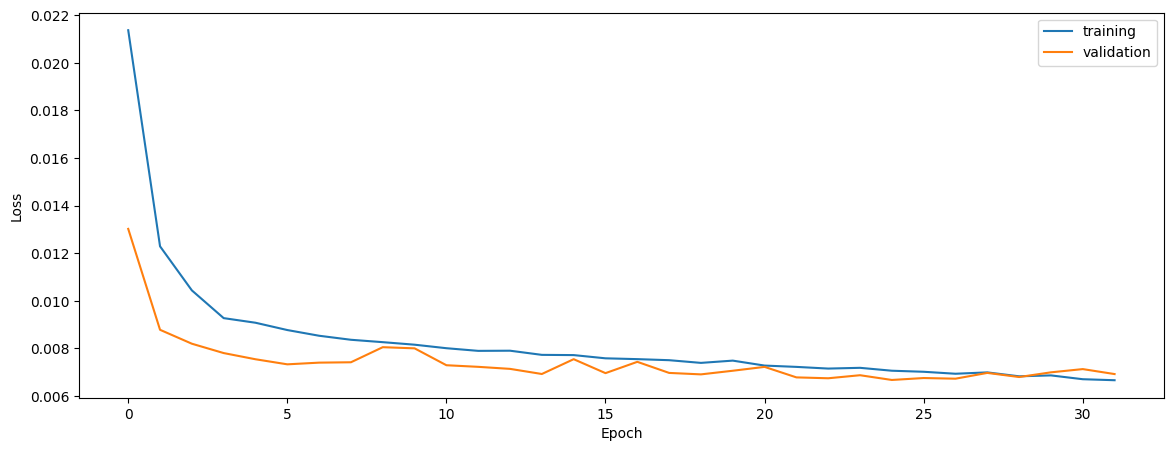

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8419021386144198
0.8299445204626301
0.8329422607179745


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.775027063051901
0.7520998441009796
0.761276836156205


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.77954262894999
0.7543163597259841
0.7691938161920517


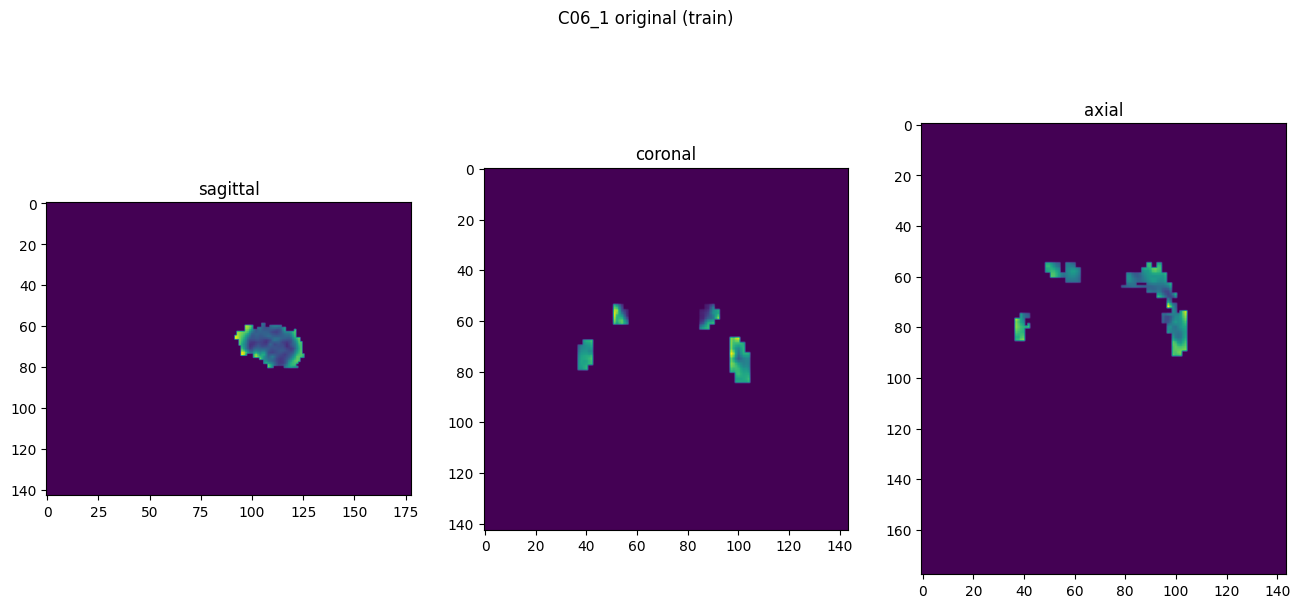

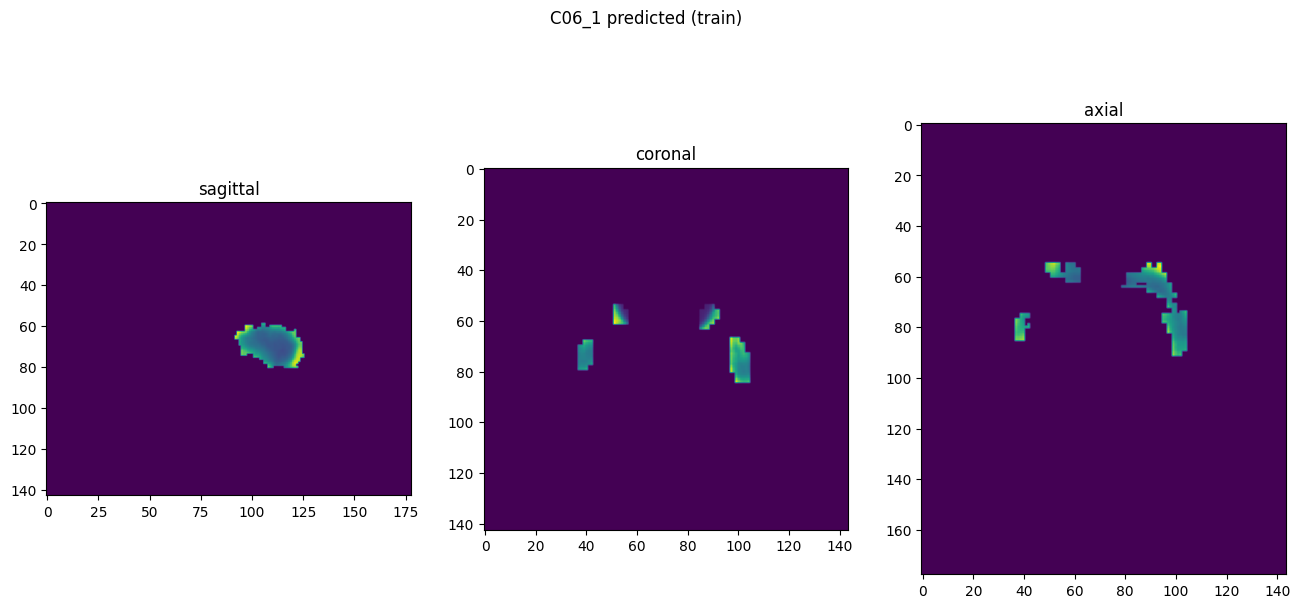

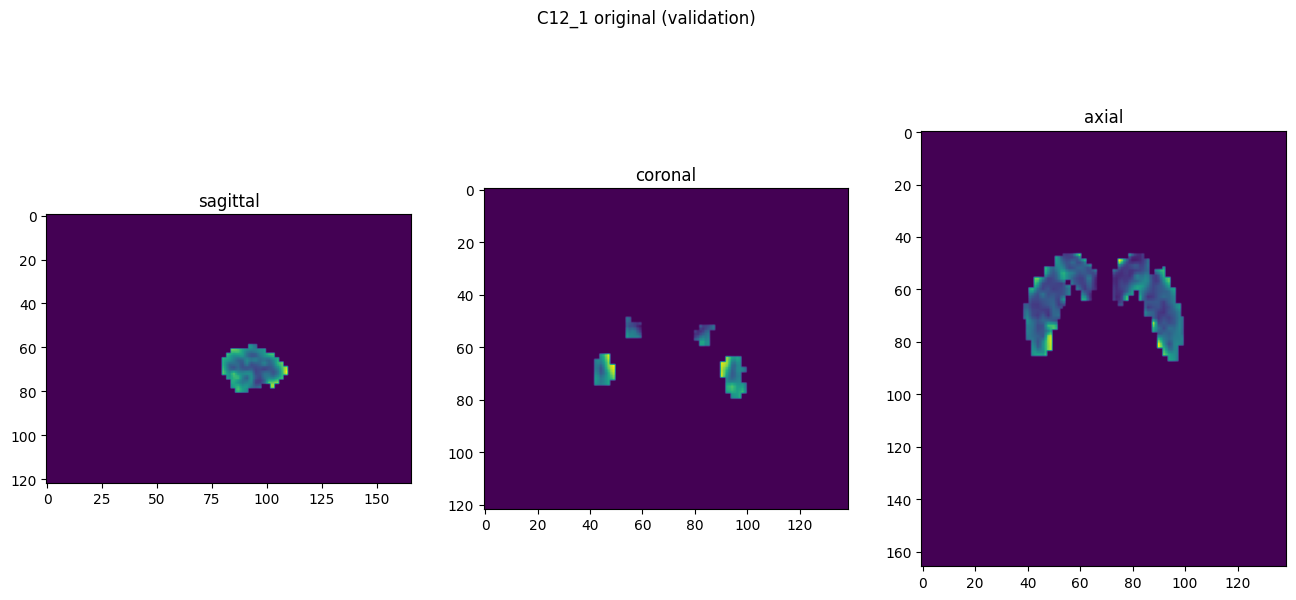

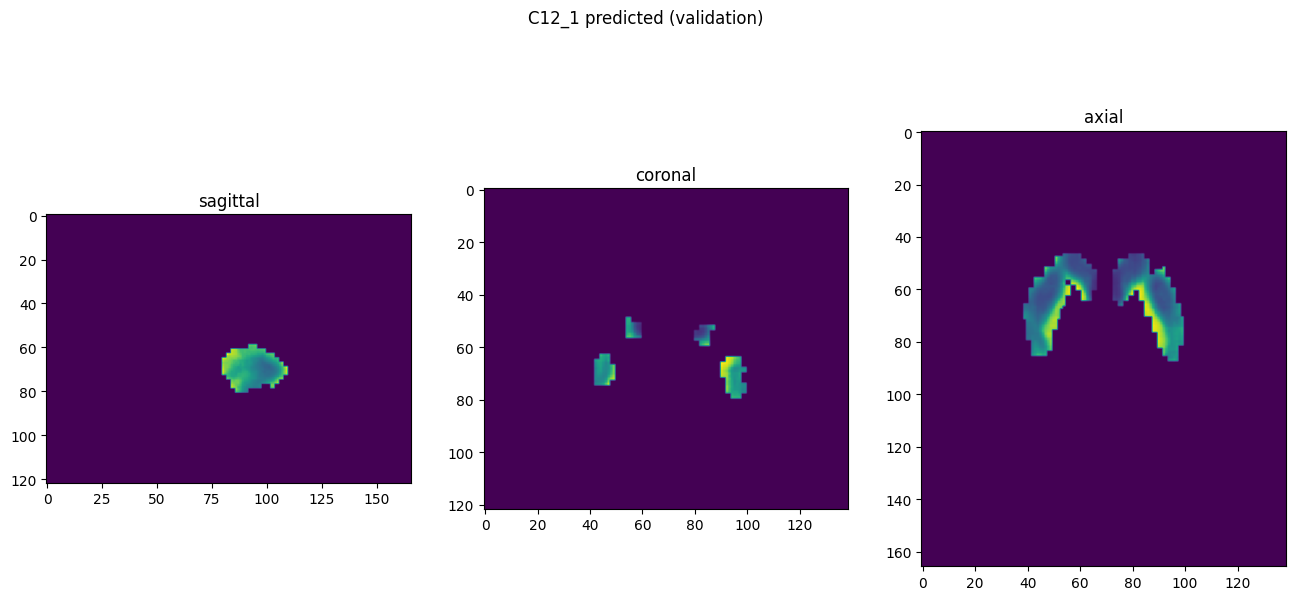

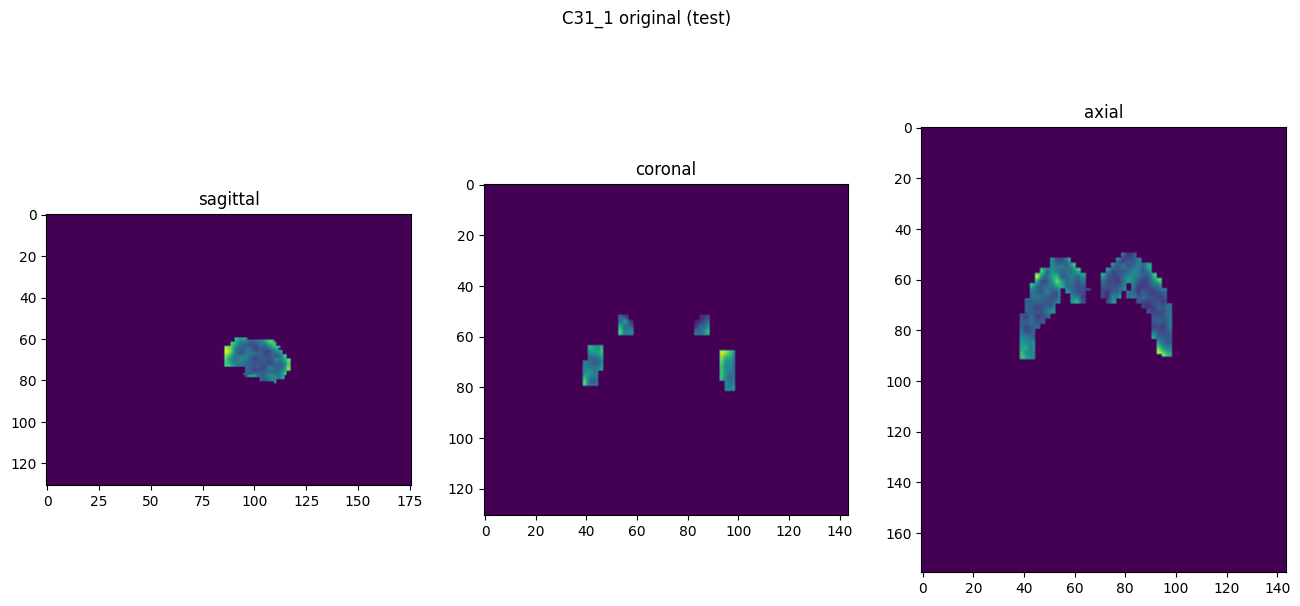

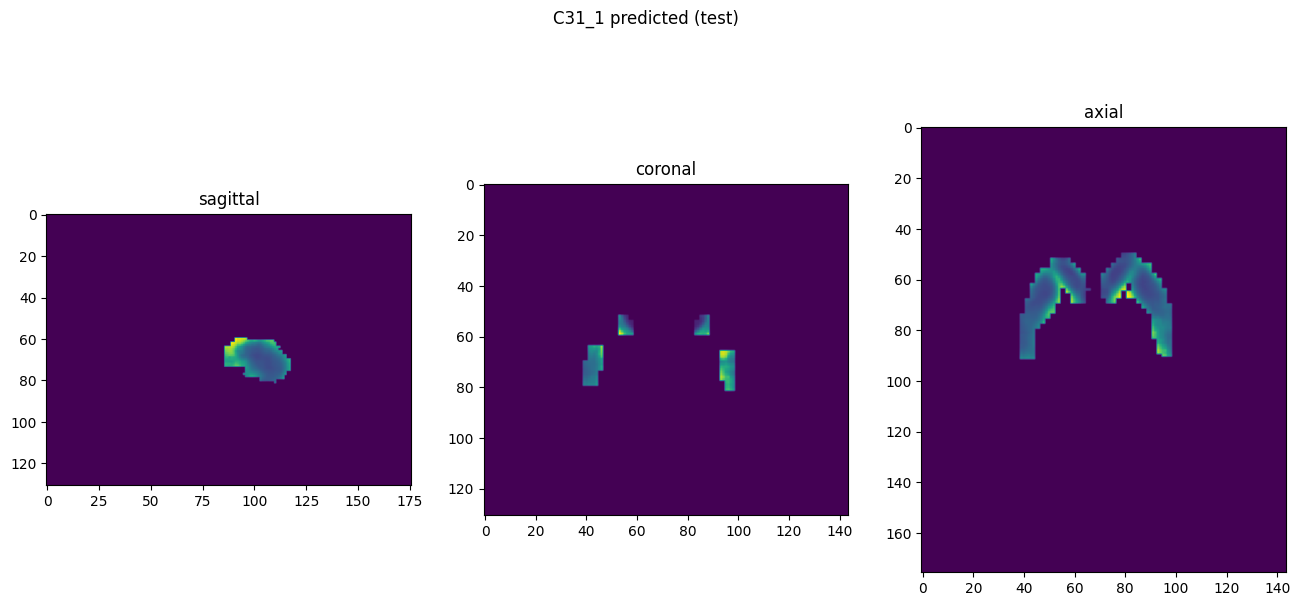

In [10]:
showResults(model, gen, threshold=None, background=False)